In [1]:
import numpy as np
import pandas as pd
import json
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import load_model
from tensorflow.keras.layers import LSTM, Dense, Embedding
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.optimizers import Adam
from keras.preprocessing.text import tokenizer_from_json

sequence_length = 13
# "/content/drive/MyDrive/Colab Notebooks/gpt/LEVX/i+d/model_llm.keras"
# "/content/drive/MyDrive/Colab Notebooks/gpt/LEVX/i+d/texts_test.csv"
# "/content/drive/MyDrive/Colab Notebooks/gpt/LEVX/i+d/tokenizer_config.json"
# /content/drive/MyDrive/metar/LECOmodel_llm.keras
#/content/drive/MyDrive/metar/LECOtokenizer_config.json
#/content/drive/MyDrive/Colab Notebooks/gpt/LECO/texts_test.csv

model_path = "/content/drive/MyDrive/Colab Notebooks/gpt/LEVX/LEVXmodel.keras"
texts_test_path = "/content/drive/MyDrive/Colab Notebooks/gpt/LEVX/LEVXtexts_test.csv"
tokenizer_path = "/content/drive/MyDrive/Colab Notebooks/gpt/LEVX/LEVXtokenizer_config.json"
result_path = "/content/drive/MyDrive/Colab Notebooks/gpt/LEVX/LEVXresult.csv"

model = load_model(model_path)
texts_test = pd.read_csv(texts_test_path, index_col="time").squeeze()

# Load the JSON configuration from the file
with open(tokenizer_path, 'r', encoding='utf-8') as f:
    tokenizer_json = json.load(f)

# Rebuild tokenizer from the JSON configuration
tokenizer = tokenizer_from_json(tokenizer_json)

In [2]:
#@title Get: X test, Y test and y_pred

sample = 300

# Function to generate text
def generate_text(seed_text, next_words=6):
    for _ in range(next_words):
        token_list = tokenizer.texts_to_sequences([seed_text])[0]
        token_list = pad_sequences([token_list], maxlen=sequence_length, padding='pre')
        predicted_probs = model.predict(token_list,verbose=0)
        predicted_index = np.argmax(predicted_probs, axis=-1)[0]
        predicted_word = tokenizer.index_word[predicted_index]
        seed_text += " " + predicted_word
    return seed_text

def get_first_n_words(text, n):
    # Split the string into words
    words = text.split()
    # Join the first n words back into a string
    return ' '.join(words[:n])

def delete_first_n_words(text, n):
    # Split the string into words
    words = text.split()
    # Remove the first n words
    del words[:n]
    # Join the remaining words back into a string
    return ' '.join(words)

def delete_words_beyond_nosig(input_string):
    # Split the string into words
    words = input_string.split()
    # Find the index of "nosig" if it exists
    try:
        index_nosig = words.index("nosig")
    except ValueError:
        # If "nosig" is not found, return the original string
        return input_string
    # Keep only the words before "nosig"
    return ' '.join(words[:index_nosig + 1])


text_test = texts_test.sample(sample)

#texts_test.to_csv("/content/drive/MyDrive/Colab Notebooks/gpt/Levx/texts_test")

all_for_text = []
y_test = []
y_pred = []

for i in range(len(text_test)):
  all_for_text.append(generate_text(get_first_n_words(text_test[i],8),11))
  y_test.append(delete_first_n_words(text_test[i], 8))
  y_pred.append(delete_words_beyond_nosig(delete_first_n_words(all_for_text[i], 8)))

result = pd.DataFrame({"y_test":y_test,"y_pred":y_pred,"all":all_for_text})
result.index=text_test.index
result.to_csv(result_path)
result
for ind in range(0,len(result)):
  display(result.iloc[ind]["y_test"])
  display(result.iloc[ind]["y_pred"])
  display(result.iloc[ind]["all"])
  #display(result.iloc[ind]["all"])
  print("*********")

'28003KT 200V350 CAVOK 15/07 Q1015 NOSIG'

'23006kt cavok 12 07 q1015 nosig'

'10009kt 9999 prec0n CL0 CM0 11 07 q1016 23006kt cavok 12 07 q1015 nosig q1016 nosig q1011 3000 ra'

*********


'VRB06KT 1500 +RA BCFG BKN007 BKN010 BKN034 12/12 Q1014 TEMPO 5000 -RA'

'23010kt 190v260 3000 ra br bkn003 bkn009 13 13 q1017 tempo'

'25011kt 500 prec0y CL6 CM0 12 12 q1017 23010kt 190v260 3000 ra br bkn003 bkn009 13 13 q1017 tempo'

*********


'34003KT 310V010 CAVOK 17/15 Q1014 TEMPO TSRA SCT030CB'

'vrb02kt cavok 21 16 q1013 nosig'

'02001kt 9999 prec0n CL0 CM0 17 16 q1013 vrb02kt cavok 21 16 q1013 nosig q1014 nosig 1500 bcfg bkn002'

*********


'00000KT CAVOK 19/17 Q1014 TEMPO 3000 BCFG BKN005'

'vrb01kt cavok 21 18 q1014 nosig'

'11003kt 9999 prec0n CL0 CM0 18 17 q1013 vrb01kt cavok 21 18 q1014 nosig q1013 nosig 1500 ra sct005'

*********


'34004KT 290V010 9000 NSC 17/16 Q1018 NOSIG'

'vrb02kt cavok 20 16 q1018 nosig'

'06001kt 9999 prec0n CL0 CM0 17 15 q1018 vrb02kt cavok 20 16 q1018 nosig q1017 nosig 16 tempo 33007kt'

*********


'02012KT 350V060 9999 FEW050 12/06 Q1008 NOSIG'

'03008kt 330v090 9999 vcts few043cb 09 06 q1009 nosig'

'01015kt 9999 prec0n CL0 CM0 10 06 q1009 03008kt 330v090 9999 vcts few043cb 09 06 q1009 nosig tempo nsw'

*********


'27003KT 240V300 CAVOK 06/01 Q1023 NOSIG'

'23005kt 200v260 cavok 07 02 q1026 nosig'

'12005kt 9999 prec0n CL0 CM0 07 03 q1027 23005kt 200v260 cavok 07 02 q1026 nosig q1026 02 02 01'

*********


'20011KT 150V230 9999 BKN012 SCT030TCU 15/13 Q1012 TEMPO 3000 RA'

'vrb08kt 9999 bkn018 13 10 q1012 nosig'

'24009kt 9999 prec0n CL3 CM0 17 10 q1012 vrb08kt 9999 bkn018 13 10 q1012 nosig q1014 nosig 1400 r19'

*********


'30009KT 270V340 9999 SCT040 21/10 Q1016 NOSIG'

'07005kt 340v150 9999 few040 20 11 q1015 nosig'

'27011kt 9999 prec0n CL0 CM0 20 13 q1016 07005kt 340v150 9999 few040 20 11 q1015 nosig nosig shra 3000'

*********


'22006KT CAVOK 12/07 Q1018 NOSIG'

'19005kt 150v220 9999 sct021 bkn048 11 09 q1019 nosig'

'17003kt 9999 prec0n CL3 CM0 10 10 q1019 19005kt 150v220 9999 sct021 bkn048 11 09 q1019 nosig q1016 nosig'

*********


'19004KT 130V220 CAVOK 19/09 Q1033 NOSIG'

'20003kt 170v230 cavok 15 11 q1033 nosig'

'16003kt 9999 prec0n CL0 CM0 18 07 q1033 20003kt 170v230 cavok 15 11 q1033 nosig 2000 br bkn005 bkn010'

*********


'19008KT 140V220 0800 R19/1900D R01/0500N RA BCFG VV001 17/17 Q1016 NOSIG'

'19009kt 110v230 0500 r19 p2000 r01 0750d ra fg ovc004 ovc007'

'19011kt 3000 prec0y CL7 CM5 17 16 q1017 19009kt 110v230 0500 r19 p2000 r01 0750d ra fg ovc004 ovc007'

*********


'24006KT 210V280 CAVOK 07/06 Q1029 NOSIG'

'02008kt 350v050 cavok 10 02 q1029 nosig'

'05007kt 9999 prec0n CL0 CM0 09 03 q1031 02008kt 350v050 cavok 10 02 q1029 nosig q1026 nosig 2000 bcfg'

*********


'VRB02KT CAVOK 09/09 Q1010 NOSIG'

'31003kt cavok 08 07 q1008 nosig'

'32003kt 9999 prec0n CL0 CM1 10 07 q1010 31003kt cavok 08 07 q1008 nosig q1009 nosig shra sct030cb bkn030'

*********


'25003KT 220V300 3000 BR BKN004 BKN008 16/16 Q1018 NOSIG'

'vrb02kt cavok 20 16 q1018 nosig'

'21001kt 9999 prec0n CL0 CM0 16 15 q1018 vrb02kt cavok 20 16 q1018 nosig q1016 nosig q1018 nosig 2000'

*********


'VRB04KT 9999 FEW018 20/15 Q1008 NOSIG'

'21005kt 140v250 cavok 19 12 q1008 nosig'

'16005kt 9999 prec0n CL0 CM0 19 12 q1008 21005kt 140v250 cavok 19 12 q1008 nosig tempo sct030cb sct030tcu 18'

*********


'03011KT 340V080 9999 SCT050 18/06 Q1014 NOSIG'

'35008kt 320v020 cavok 20 07 q1014 nosig'

'35011kt 9999 prec0n CL0 CM0 19 09 q1015 35008kt 320v020 cavok 20 07 q1014 nosig nosig nosig 3000 ra'

*********


'27010KT 230V300 9999 SCT029 19/13 Q1016 NOSIG'

'28009kt 250v320 9999 few040 21 15 q1016 nosig'

'31009kt 9999 prec0n CL4 CM1 20 14 q1016 28009kt 250v320 9999 few040 21 15 q1016 nosig nosig nosig 2000'

*********


'19004KT 100V250 5000 BR BKN003 OVC007 14/14 Q1013 TEMPO 0350 FG'

'vrb01kt 9999 few040 14 12 q1011 nosig'

'14003kt 9999 prec0n CL0 CM0 11 11 q1012 vrb01kt 9999 few040 14 12 q1011 nosig q1009 nosig 14 nosig'

*********


'20004KT 160V240 0100 R19/0450N R01/0300N BCFG -RA VV001 13/13 Q1029 TEMPO 0600'

'22006kt 190v250 5000 bcfg sct002 13 12 q1029 tempo 3000 br'

'16003kt 3000 prec0y CL0 CM0 12 12 q1030 22006kt 190v250 5000 bcfg sct002 13 12 q1029 tempo 3000 br'

*********


'VRB03KT CAVOK 02/01 Q1020 NOSIG'

'04011g24kt 010v070 9999 few050 03 m00 q1020 nosig'

'00011kt 9999 prec0n CL0 CM0 03 00 q1021 04011g24kt 010v070 9999 few050 03 m00 q1020 nosig tempo nsw ovc023'

*********


'00000KT CAVOK 17/16 Q1017 NOSIG'

'vrb01kt cavok 16 14 q1017 nosig'

'31003kt 9999 prec0n CL0 CM0 14 13 q1017 vrb01kt cavok 16 14 q1017 nosig q1017 nosig 2000 bcfg bkn003'

*********


'19008KT 150V210 9999 0800E -RA BCFG FEW002 BKN031 04/03 Q0997 TEMPO 0800 BCFG BKN002'

'20010kt 150v230 9999 shra sct015tcu r01 0650d few004 03 02 q1000'

'18009kt 9999 prec0n CL0 CM0 05 03 q0997 20010kt 150v230 9999 shra sct015tcu r01 0650d few004 03 02 q1000'

*********


'02011KT 350V070 CAVOK 19/12 Q1017 NOSIG'

'03006kt 350v080 cavok 17 12 q1018 nosig'

'01009kt 9999 prec0n CL0 CM0 17 11 q1018 03006kt 350v080 cavok 17 12 q1018 nosig q1019 nosig 2000 ra'

*********


'26011KT 230V300 9999 SCT013 SCT025TCU 21/19 Q1015 NOSIG'

'24008kt 200v290 9999 sct007 bkn022 20 18 q1016 becmg ovc013 nsw'

'26011kt 9999 prec0n CL5 CM3 21 17 q1015 24008kt 200v290 9999 sct007 bkn022 20 18 q1016 becmg ovc013 nsw'

*********


'19009KT 150V230 1100 R19/P2000 R01/1100U RA VV001 14/14 Q1016 TEMPO 9999 NSW'

'20007kt 9999 few014 bkn040 15 15 q1016 tempo 3000 br bkn010'

'14005kt 9999 prec0n CL6 CM4 14 13 q1016 20007kt 9999 few014 bkn040 15 15 q1016 tempo 3000 br bkn010'

*********


'20006KT 160V240 CAVOK 08/07 Q1015 NOSIG'

'vrb02kt cavok 10 06 q1015 nosig'

'17005kt 9999 prec0n CL0 CM0 08 06 q1016 vrb02kt cavok 10 06 q1015 nosig q1015 nosig 1500 bcfg bkn003'

*********


'24004KT 200V270 CAVOK 10/07 Q1032 NOSIG'

'24004kt cavok 08 04 q1029 nosig'

'26001kt 9999 prec0n CL0 CM0 08 04 q1032 24004kt cavok 08 04 q1029 nosig q1030 nosig q1026 nosig 1500n'

*********


'33003KT 280V030 9999 SCT020 SCT040 19/13 Q1013 NOSIG'

'vrb03kt 9999 bkn015 bkn048 17 14 q1012 nosig'

'01005kt 9999 prec0n CL3 CM1 21 12 q1012 vrb03kt 9999 bkn015 bkn048 17 14 q1012 nosig nosig q1017 0500'

*********


'VRB01KT CAVOK 14/11 Q1016 NOSIG'

'vrb02kt cavok 13 11 q1017 nosig'

'12003kt 9999 prec0n CL0 CM0 12 10 q1017 vrb02kt cavok 13 11 q1017 nosig q1018 nosig 2000 bcfg bkn002'

*********


'20006KT 170V230 0100 R19/0450D R01/0375N FG VV001 07/07 Q1019 TEMPO 1000 BCFG'

'23005kt cavok 09 08 q1018 nosig'

'16003kt 9999 prec0n CL0 CM0 08 07 q1019 23005kt cavok 09 08 q1018 nosig q1019 nosig 2000 bcfg ra'

*********


'03003KT 340V080 CAVOK 07/06 Q1021 NOSIG'

'02009kt 350v060 cavok 10 06 q1021 nosig'

'36011kt 9999 prec0n CL0 CM0 08 06 q1021 02009kt 350v060 cavok 10 06 q1021 nosig q1029 fg bkn005 ovc017'

*********


'28009KT CAVOK 22/17 Q1020 NOSIG'

'28009kt 240v300 cavok 22 13 q1021 nosig'

'28011kt 9999 prec0n CL0 CM0 20 13 q1021 28009kt 240v300 cavok 22 13 q1021 nosig nosig nosig 2000 ra'

*********


'01007KT 340V070 9999 FEW030 16/10 Q1024 NOSIG'

'vrb02kt cavok 16 10 q1025 nosig'

'02005kt 9999 prec0n CL0 CM0 17 08 q1026 vrb02kt cavok 16 10 q1025 nosig q1025 nosig 2000 bcfg vv001'

*********


'25002KT CAVOK 14/13 Q1018 NOSIG'

'00000kt cavok 14 12 q1018 nosig'

'20001kt 9999 prec0n CL0 CM0 12 11 q1018 00000kt cavok 14 12 q1018 nosig q1016 nosig q1019 3000 ra'

*********


'36007KT 330V080 9999 SCT020 BKN035 23/19 Q1016 NOSIG'

'27009kt 240v320 cavok 23 18 q1014 nosig'

'28009kt 9999 prec0n CL0 CM0 20 19 q1015 27009kt 240v320 cavok 23 18 q1014 nosig q1014 nosig 0800 fg'

*********


'21006KT 9999 SCT033 BKN050 10/08 Q1010 NOSIG'

'23005kt 9999 few036 09 08 q1010 nosig'

'18003kt 9999 prec0n CL2 CM0 08 07 q1011 23005kt 9999 few036 09 08 q1010 nosig 4000 shra sct025tcu sct006'

*********


'19003KT 140V240 0800 R19/P2000 R01/1200U FG BKN002 09/09 Q1015 TEMPO 3000 SHRA SCT025TCU'

'vrb02kt 9999 sct014 bkn035 14 12 q1014 nosig'

'33007kt 9999 prec0n CL6 CM0 12 07 q1014 vrb02kt 9999 sct014 bkn035 14 12 q1014 nosig q1014 nosig q1020'

*********


'VRB01KT CAVOK 16/15 Q1020 NOSIG'

'04003kt cavok 13 12 q1021 nosig'

'03003kt 9999 prec0n CL0 CM0 13 11 q1021 04003kt cavok 13 12 q1021 nosig q1020 nosig tempo bkn005 13'

*********


'36010KT CAVOK 10/05 Q1031 NOSIG'

'35010kt 320v020 9999 sct029 bkn040 09 07 q1034 nosig'

'29007kt 9999 prec0n CL0 CM0 08 07 q1034 35010kt 320v020 9999 sct029 bkn040 09 07 q1034 nosig q1033 nosig'

*********


'28004KT 240V300 CAVOK 24/20 Q1015 NOSIG'

'vrb01kt cavok 24 19 q1016 nosig'

'30005kt 9999 prec0n CL0 CM0 22 16 q1016 vrb01kt cavok 24 19 q1016 nosig q1015 nosig 0800 bcfg bkn004'

*********


'20003KT 160V230 0300 R19/P2000 R01/1400N BCFG VV001 11/11 Q1009 TEMPO 3000 SHRA SCT030TCU'

'vrb02kt 9999 few045 10 09 q1008 nosig'

'30003kt 9999 prec0n CL5 CM5 10 09 q1008 vrb02kt 9999 few045 10 09 q1008 nosig shra bkn012 ovc022 10'

*********


'03003KT 280V140 CAVOK 21/17 Q1013 TEMPO TSRA'

'vrb02kt cavok 24 19 q1014 nosig'

'28009kt 9999 prec0n CL0 CM0 24 16 q1013 vrb02kt cavok 24 19 q1014 nosig nosig nosig 1400 bcfg bkn005'

*********


'03007KT CAVOK 07/07 Q1027 NOSIG'

'02006kt 350v050 cavok 09 05 q1027 nosig'

'01011kt 9999 prec0n CL0 CM0 08 05 q1028 02006kt 350v050 cavok 09 05 q1027 nosig q1027 01 02 q1025'

*********


'07012G25KT 010V140 9999 FEW030 11/M03 Q1027 NOSIG'

'22003kt 190v310 cavok 09 02 q1029 nosig'

'05025kt 9999 prec0n CL0 CM0 08 01 q1029 22003kt 190v310 cavok 09 02 q1029 nosig q1024 02 q1006 r19'

*********


'20009KT 140V230 9999 SCT023 20/16 Q1021 NOSIG'

'18007kt 100v220 2000 bcfg dz bkn003 bkn008 18 18 q1021 nosig'

'16009kt 9999 prec0n CL4 CM0 18 16 q1020 18007kt 100v220 2000 bcfg dz bkn003 bkn008 18 18 q1021 nosig'

*********


'20006KT 110V240 9999 FEW015 18/13 Q1020 NOSIG'

'21006kt cavok 20 14 q1019 nosig'

'17007kt 9999 prec0n CL0 CM0 15 11 q1019 21006kt cavok 20 14 q1019 nosig q1020 nosig 2000 bcfg bkn003'

*********


'19012KT 120V220 0300 R19/1700U R01/0450D FG VV001 09/09 Q1016 NOSIG'

'18008kt 100v230 9999 few006 11 11 q1017 nosig'

'17009kt 9999 prec0n CL7 CM4 09 09 q1017 18008kt 100v230 9999 few006 11 11 q1017 nosig q1017 nosig tempo'

*********


'03003KT 340V090 CAVOK 11/08 Q1021 NOSIG'

'vrb02kt cavok 09 08 q1021 nosig'

'03003kt 9999 prec0n CL0 CM0 09 07 q1021 vrb02kt cavok 09 08 q1021 nosig q1021 nosig q1030 3000 ra'

*********


'36012KT 9999 -DZ SCT015 SCT020 BKN035 09/07 Q1024 NOSIG'

'01009kt 330v070 9999 bkn040 11 06 q1024 nosig'

'01015kt 9999 prec0n CL2 CM0 11 05 q1025 01009kt 330v070 9999 bkn040 11 06 q1024 nosig q1025 7000 ra'

*********


'VRB05KT 8000 RA SCT031 BKN042 15/13 Q1014 NOSIG'

'01012kt 340v040 9999 few017 18 12 q1013 nosig'

'01013kt 9999 prec0n CL3 CM0 17 12 q1013 01012kt 340v040 9999 few017 18 12 q1013 nosig q1016 nosig 2000'

*********


'00000KT CAVOK 07/07 Q1028 NOSIG'

'24006kt cavok 10 08 q1029 nosig'

'27001kt 9999 prec0n CL0 CM0 08 06 q1029 24006kt cavok 10 08 q1029 nosig q1027 nosig q1030 nosig q1024'

*********


'19006KT 150V220 CAVOK 15/14 Q1017 TEMPO 3000 RA'

'20006kt 160v230 9000 dz sct016 bkn022 bkn047 15 15 q1019 nosig'

'18003kt 9999 prec0n CL6 CM0 14 14 q1018 20006kt 160v230 9000 dz sct016 bkn022 bkn047 15 15 q1019 nosig'

*********


'21005KT 170V250 9999 OVC045 11/07 Q1026 NOSIG'

'18009kt 9999 few026 11 08 q1026 nosig'

'16009kt 8000 prec0y CL6 CM2 10 07 q1027 18009kt 9999 few026 11 08 q1026 nosig q1027 nosig 09 09'

*********


'23006KT CAVOK 13/05 Q1023 NOSIG'

'23005kt cavok 12 08 q1023 nosig'

'16003kt 9999 prec0n CL0 CM0 10 07 q1024 23005kt cavok 12 08 q1023 nosig q1023 nosig bkn010 bkn018 0650n'

*********


'21006KT 170V230 CAVOK 05/01 Q1032 NOSIG'

'23004kt 190v270 cavok 07 02 q1032 nosig'

'15005kt 9999 prec0n CL0 CM0 08 02 q1034 23004kt 190v270 cavok 07 02 q1032 nosig nosig 7000 ra sct003'

*********


'VRB01KT CAVOK 14/13 Q1022 NOSIG'

'vrb01kt cavok 16 14 q1022 nosig'

'15001kt 9999 prec0n CL0 CM0 13 12 q1022 vrb01kt cavok 16 14 q1022 nosig q1022 tempo 3000 ra br'

*********


'28010KT 250V330 9999 SCT025 23/17 Q1016 NOSIG'

'28010kt 240v310 9999 few035 22 15 q1017 nosig'

'28011kt 9999 prec0n CL0 CM0 22 15 q1017 28010kt 240v310 9999 few035 22 15 q1017 nosig nosig 1000 ra'

*********


'21006KT 9999 BKN030 10/07 Q1030 NOSIG'

'22006kt cavok 09 08 q1030 nosig'

'16005kt 9999 prec0n CL0 CM0 09 07 q1031 22006kt cavok 09 08 q1030 nosig q1029 nosig q1029 nosig q1026'

*********


'05003KT 010V130 CAVOK 30/16 Q1020 NOSIG'

'vrb03kt cavok 31 13 q1021 q1021 nosig'

'28005kt 9999 prec0n CL0 CM0 28 16 q1021 vrb03kt cavok 31 13 q1021 q1021 nosig nosig tempo sct015 bkn015'

*********


'VRB02KT 6000 BCFG SCT005 BKN010 13/11 Q1014 TEMPO 1500 BCFG BKN005'

'27004kt 230v310 1400 0800n r19 1900n r01 p2000 bcfg bkn003 bkn005'

'29007kt 500 prec0n CL4 CM0 11 11 q1015 27004kt 230v310 1400 0800n r19 1900n r01 p2000 bcfg bkn003 bkn005'

*********


'24014KT 200V270 3000 -RA BR BKN002 OVC007 16/15 Q1016 NOSIG'

'22010kt 190v250 9999 few006 sct011 bkn018 15 14 q1017 tempo 3000'

'23011kt 9999 prec0n CL6 CM2 16 14 q1016 22010kt 190v250 9999 few006 sct011 bkn018 15 14 q1017 tempo 3000'

*********


'23004KT 0800 R19/1900N R01/1800D SHRA FG SCT002 SCT029TCU BKN035 13/13 Q1009 TEMPO 3000 -RA'

'23003kt 170v260 7000 bkn003 bkn009 13 13 q1008 tempo 3000 ra'

'26001kt 9999 prec0n CL2 CM2 13 12 q1009 23003kt 170v260 7000 bkn003 bkn009 13 13 q1008 tempo 3000 ra'

*********


'28009KT 240V320 9999 BKN036 13/10 Q1025 NOSIG'

'35002kt cavok 13 09 q1026 nosig'

'31005kt 9999 prec0n CL0 CM0 13 08 q1027 35002kt cavok 13 09 q1026 nosig q1027 nosig q1026 02 q1025'

*********


'VRB01KT CAVOK 20/18 Q1018 NOSIG'

'00000kt cavok 20 16 q1019 nosig'

'15003kt 9999 prec0n CL0 CM0 16 15 q1019 00000kt cavok 20 16 q1019 nosig q1020 nosig 0800 r19 p2000'

*********


'VRB04KT 9999 FEW030 24/17 Q1015 NOSIG'

'24007kt 210v320 cavok 23 17 q1016 nosig'

'26005kt 9999 prec0n CL0 CM0 24 17 q1016 24007kt 210v320 cavok 23 17 q1016 nosig q1015 nosig 1400 r19'

*********


'21001KT 3500 -RA BR FEW002 SCT007 BKN018 15/15 Q1009 NOSIG'

'07003kt 030v110 cavok 19 17 q1008 nosig'

'29007kt 9999 prec0n CL4 CM0 16 15 q1007 07003kt 030v110 cavok 19 17 q1008 nosig q1009 nosig 2000 shra'

*********


'VRB01KT CAVOK 11/08 Q1020 NOSIG'

'18009kt 9999 bcfg few033 sct044 bkn050 10 08 q1019 tempo 3000'

'17007kt 9999 prec0n CL0 CM0 10 07 q1020 18009kt 9999 bcfg few033 sct044 bkn050 10 08 q1019 tempo 3000'

*********


'27011KT CAVOK 16/12 Q1022 NOSIG'

'27011kt 240v310 9999 few025 17 12 q1023 nosig'

'28011kt 9999 prec0n CL0 CM0 15 11 q1023 27011kt 240v310 9999 few025 17 12 q1023 nosig q1023 nosig fg'

*********


'20004KT 140V230 9999 SCT026 16/13 Q1023 NOSIG'

'vrb02kt cavok 15 12 q1023 nosig'

'16005kt 9999 prec0n CL0 CM0 13 11 q1023 vrb02kt cavok 15 12 q1023 nosig q1020 nosig tempo 0900 fg'

*********


'04009KT 350V100 CAVOK 18/13 Q1024 NOSIG'

'36007kt cavok 17 12 q1023 nosig'

'02009kt 9999 prec0n CL0 CM0 17 12 q1025 36007kt cavok 17 12 q1023 nosig q1021 nosig 14 0300 r19'

*********


'29009G24KT 200V350 9000 BKN020 BKN030 OVC046 10/07 Q1005 RERA TEMPO 3000 RA BKN010'

'03006kt 340v080 9999 sct014 bkn021 09 08 q1005 tempo 3000 shra'

'31013kt 2000 prec0y CL0 CM0 09 08 q1005 03006kt 340v080 9999 sct014 bkn021 09 08 q1005 tempo 3000 shra'

*********


'23003KT 200V260 9999 FEW023 09/08 Q1003 NOSIG'

'26003kt 230v290 1400 r01 1100u r01 0300d bcfg few001 09 09'

'22003kt 9999 prec0n CL0 CM1 10 09 q1003 26003kt 230v290 1400 r01 1100u r01 0300d bcfg few001 09 09'

*********


'32010KT 270V340 3000 RA BR SCT024 BKN039 BKN050 07/05 Q1020 NOSIG'

'30007kt 260v350 9999 sct034 bkn040 08 06 q1020 nosig'

'31013kt 9999 prec0n CL3 CM0 08 05 q1021 30007kt 260v350 9999 sct034 bkn040 08 06 q1020 nosig q1030 nosig'

*********


'VRB02KT 9999 FEW015 BKN036 14/10 Q1029 NOSIG'

'vrb01kt 9999 sct015 bkn020 13 11 q1030 nosig'

'19003kt 9999 prec0n CL3 CM0 13 10 q1030 vrb01kt 9999 sct015 bkn020 13 11 q1030 nosig q1029 fg bkn005'

*********


'22008KT 190V250 CAVOK 20/12 Q1013 NOSIG'

'23004kt cavok 20 16 q1014 nosig'

'15003kt 9999 prec0n CL0 CM0 18 12 q1014 23004kt cavok 20 16 q1014 nosig q1016 nosig 0500 r19 1200d'

*********


'24009KT 220V280 9999 SCT023 SCT029 BKN044 19/15 Q1018 NOSIG'

'25007kt 220v290 9999 sct006 bkn010 ovc020 18 17 q1019 tempo 3000'

'23007kt 9999 prec0n CL1 CM0 18 15 q1018 25007kt 220v290 9999 sct006 bkn010 ovc020 18 17 q1019 tempo 3000'

*********


'VRB02KT CAVOK 07/06 Q1022 NOSIG'

'vrb01kt cavok 08 07 q1022 nosig'

'16001kt 9999 prec0n CL0 CM0 07 06 q1022 vrb01kt cavok 08 07 q1022 nosig q1023 nosig 09 2000 bcfg'

*********


'27007KT 230V310 9999 SCT024 BKN032 15/12 Q1013 NOSIG'

'24006kt 200v280 9000 nsc 15 12 q1013 nosig'

'27007kt 9999 prec0n CL0 CM0 13 12 q1013 24006kt 200v280 9000 nsc 15 12 q1013 nosig q1013 200v290 tempo'

*********


'28007KT 230V330 9999 BKN014 BKN021 10/08 Q1018 TEMPO 3000 RA'

'vrb02kt 9000 ra sct010 bkn020 10 09 q1017 tempo 3000 ra'

'28013kt 9999 prec0y CL5 CM0 10 09 q1018 vrb02kt 9000 ra sct010 bkn020 10 09 q1017 tempo 3000 ra'

*********


'VRB02KT 6000 RA FEW032 BKN039 BKN048 09/08 Q1013 TEMPO 0350 FG RA VV001'

'18005kt 140v230 4000 ra bcfg sct009 bkn015 bkn021 09 09 q1012'

'17007kt 9999 prec0n CL5 CM3 09 08 q1014 18005kt 140v230 4000 ra bcfg sct009 bkn015 bkn021 09 09 q1012'

*********


'01009KT CAVOK 18/12 Q1017 NOSIG'

'03007kt 350v060 cavok 17 12 q1018 nosig'

'01009kt 9999 prec0n CL0 CM0 17 12 q1018 03007kt 350v060 cavok 17 12 q1018 nosig q1019 nosig 2000 bcfg'

*********


'VRB06KT CAVOK 23/13 Q1025 NOSIG'

'vrb03kt cavok 23 12 q1024 nosig'

'32005kt 9999 prec0n CL0 CM0 23 13 q1025 vrb03kt cavok 23 12 q1024 nosig q1024 nosig 16007kt few003 sct001'

*********


'01009KT 340V110 9999 SCT040 20/12 Q1022 NOSIG'

'35008kt 290v060 9999 few040 21 13 q1021 nosig'

'31009kt 9999 prec0n CL0 CM0 19 13 q1021 35008kt 290v060 9999 few040 21 13 q1021 nosig nosig 0300 r19'

*********


'02012KT 330V080 CAVOK 18/11 Q1019 NOSIG'

'01013kt 340v060 cavok 16 11 q1018 nosig'

'36013kt 9999 prec0n CL0 CM0 15 12 q1020 01013kt 340v060 cavok 16 11 q1018 nosig 2000 bcfg bkn003 ovc015'

*********


'06015G29KT 360V100 9999 FEW030 09/M01 Q1018 NOSIG'

'05014g24kt 350v100 9999 sct040 08 05 q1020 nosig'

'02017kt 9999 prec0n CL0 CM0 08 02 q1020 05014g24kt 350v100 9999 sct040 08 05 q1020 nosig q1020 nosig tempo'

*********


'VRB02KT 2500 BR FEW002 17/17 Q1015 TEMPO 0350 FG VV001'

'vrb02kt 0300 r19 0300n r01 0500n fg vv001 16 16 q1015'

'35003kt 9999 prec0n CL0 CM0 14 14 q1015 vrb02kt 0300 r19 0300n r01 0500n fg vv001 16 16 q1015'

*********


'24004KT 200V280 CAVOK 12/07 Q1021 NOSIG'

'vrb02kt cavok 12 06 q1020 nosig'

'16005kt 9999 prec0n CL0 CM0 11 06 q1021 vrb02kt cavok 12 06 q1020 nosig q1021 q1030 nosig q1024 nosig'

*********


'21005KT 8000 BCFG NSC 04/04 Q1029 NOSIG'

'23006kt cavok 06 03 q1029 nosig'

'17003kt 9999 prec0n CL0 CM0 07 03 q1030 23006kt cavok 06 03 q1029 nosig q1029 nosig q1026 01 q1026'

*********


'29008KT 260V320 9999 SCT014 18/15 Q1020 TEMPO BKN010'

'29013kt 9999 few019 19 16 q1020 nosig'

'29011kt 9999 prec0n CL0 CM0 17 15 q1021 29013kt 9999 few019 19 16 q1020 nosig q1020 nosig 2000 ra'

*********


'VRB03KT CAVOK 22/15 Q1016 NOSIG'

'25006kt 220v300 cavok 24 14 q1015 nosig'

'28005kt 9999 prec0n CL0 CM0 23 14 q1015 25006kt 220v300 cavok 24 14 q1015 nosig nosig nosig 2000 bcfg'

*********


'05006KT 340V130 9999 FEW030 20/12 Q1020 NOSIG'

'07004kt 360v120 cavok 19 12 q1019 nosig'

'01007kt 9999 prec0n CL0 CM0 19 11 q1019 07004kt 360v120 cavok 19 12 q1019 nosig nosig 0200 r19 0650d'

*********


'27007KT 230V320 9999 FEW025 20/15 Q1013 NOSIG'

'23005kt 190v300 cavok 19 11 q1013 nosig'

'26009kt 9999 prec0n CL0 CM0 20 11 q1013 23005kt 190v300 cavok 19 11 q1013 nosig 3000 br bkn010 bkn030'

*********


'36005KT CAVOK 16/14 Q1026 NOSIG'

'34003kt cavok 15 14 q1026 nosig'

'36005kt 9999 prec0n CL0 CM0 13 13 q1027 34003kt cavok 15 14 q1026 nosig q1025 nosig 2000 ra bcfg'

*********


'20006KT 160V230 CAVOK 15/11 Q1021 NOSIG'

'vrb01kt cavok 15 10 q1022 nosig'

'17003kt 9999 prec0n CL0 CM0 13 10 q1022 vrb01kt cavok 15 10 q1022 nosig q1023 nosig 14 22003kt q1019'

*********


'26006KT 220V290 9999 FEW030 24/11 Q1015 NOSIG'

'27004g18kt 320v040 9999 sct036 sct035 21 13 q1019 nosig'

'22005kt 9999 prec0n CL4 CM5 23 13 q1019 27004g18kt 320v040 9999 sct036 sct035 21 13 q1019 nosig 0800 fg'

*********


'30003KT 240V340 9999 SCT025 10/06 Q1015 NOSIG'

'31006g19kt 250v030 9999 sct023tcu sct033 10 05 q1015 nosig'

'29009kt 9999 prec0n CL1 CM0 09 07 q1016 31006g19kt 250v030 9999 sct023tcu sct033 10 05 q1015 nosig tempo nsw'

*********


'02011G23KT 340V060 CAVOK 17/11 Q1020 NOSIG'

'36015kt cavok 16 11 q1020 nosig'

'01013kt 9999 prec0n CL0 CM0 15 12 q1021 36015kt cavok 16 11 q1020 nosig q1019 nosig bkn012 14 14'

*********


'22006KT 0300 R19/0350N R01/0300N FZFG VV001 M00/M00 Q1012 NOSIG'

'00000kt cavok 03 m01 q1014 nosig'

'03005kt 9999 prec0n CL0 CM0 03 00 q1013 00000kt cavok 03 m01 q1014 nosig nosig nosig 02 q1013 r19'

*********


'00000KT CAVOK 05/04 Q1032 NOSIG'

'20005kt 150v230 cavok 05 04 q1031 nosig'

'14003kt 9999 prec0n CL0 CM0 06 04 q1033 20005kt 150v230 cavok 05 04 q1031 nosig q1033 01 fg bkn042'

*********


'06005KT 330V110 CAVOK 18/12 Q1025 NOSIG'

'01007kt 340v040 cavok 19 09 q1024 nosig'

'36007kt 9999 prec0n CL0 CM0 16 09 q1025 01007kt 340v040 cavok 19 09 q1024 nosig nosig nosig 20004kt bcfg'

*********


'19005KT 140V220 9999 BKN016 BKN031 17/15 Q1018 NOSIG'

'19005kt 150v230 0300 r19 p2000 r01 0500n fg vv001 17 17'

'18005kt 9999 prec0n CL5 CM0 15 15 q1018 19005kt 150v230 0300 r19 p2000 r01 0500n fg vv001 17 17'

*********


'16005KT 070V240 7000 SCT006 BKN012 BKN020 08/08 Q1015 TEMPO 1500 -RA'

'18006kt 9999 bkn026 bkn043 08 07 q1016 nosig'

'15007kt 9999 prec0n CL5 CM4 08 05 q1016 18006kt 9999 bkn026 bkn043 08 07 q1016 nosig q1015 nosig bkn012'

*********


'03004KT 350V080 CAVOK 07/07 Q1010 NOSIG'

'05006kt 020v080 cavok 07 00 q1012 nosig'

'01009kt 9999 prec0n CL0 CM0 08 04 q1011 05006kt 020v080 cavok 07 00 q1012 nosig q1015 nosig nosig bkn021'

*********


'07004KT 360V140 9999 SCT012 BKN019 21/17 Q1019 NOSIG'

'28004kt 240v320 cavok 20 12 q1019 nosig'

'29003kt 9999 prec0n CL0 CM1 19 11 q1019 28004kt 240v320 cavok 20 12 q1019 nosig q1020 nosig 2000 1000e'

*********


'27007KT 210V310 9999 FEW021 SCT028 19/15 Q1018 NOSIG'

'vrb02kt 9999 sct024 21 16 q1018 nosig'

'31005kt 9999 prec0n CL6 CM0 19 14 q1018 vrb02kt 9999 sct024 21 16 q1018 nosig nosig 0500 r19 1200u'

*********


'VRB02KT 9999 BKN031 07/04 Q1014 NOSIG'

'16005kt 080v230 9000 ovc003 08 07 q1012 nosig'

'35019kt 5000 prec0n CL0 CM2 09 05 q1012 16005kt 080v230 9000 ovc003 08 07 q1012 nosig nosig rwy nosig'

*********


'28004KT 240V320 CAVOK 17/12 Q1016 NOSIG'

'27011kt 240v310 9999 few023 15 10 q1017 nosig'

'28011kt 9999 prec0n CL0 CM0 17 10 q1017 27011kt 240v310 9999 few023 15 10 q1017 nosig tempo nsw cavok'

*********


'VRB02KT 9999 FEW007 SCT032 14/12 Q1019 NOSIG'

'vrb01kt cavok 16 14 q1019 nosig'

'29005kt 9999 prec0n CL0 CM0 15 14 q1019 vrb01kt cavok 16 14 q1019 nosig 2000 br bkn005 bkn010 ovc026'

*********


'VRB03KT 9999 SCT018 17/12 Q1020 NOSIG'

'vrb04kt 9999 few035 21 13 q1021 nosig'

'29009kt 9999 prec0n CL0 CM0 19 12 q1021 vrb04kt 9999 few035 21 13 q1021 nosig q1021 nosig bkn005 bkn009'

*********


'04004KT 350V110 9999 BKN030 11/11 Q1012 NOSIG'

'01009kt 340v050 9999 ra few002 sct010 bkn018 09 09 q1013 nosig'

'00011kt 9999 prec0n CL4 CM2 11 09 q1013 01009kt 340v050 9999 ra few002 sct010 bkn018 09 09 q1013 nosig'

*********


'VRB02KT 0800 R19/1000U R01/0800U FG VV001 18/18 Q1013 TEMPO 0350 FG VV001'

'vrb02kt cavok 20 18 q1014 nosig'

'12001kt 9999 prec0n CL0 CM0 18 17 q1013 vrb02kt cavok 20 18 q1014 nosig q1013 nosig 1500 bcfg bkn005'

*********


'19023G35KT 140V220 CAVOK 16/06 Q1024 NOSIG'

'vrb13g27kt 9999 bkn020 15 11 q1025 nosig'

'17025kt 9999 prec0n CL0 CM0 14 08 q1024 vrb13g27kt 9999 bkn020 15 11 q1025 nosig q1025 tempo 3000 br'

*********


'28009KT CAVOK 17/14 Q1018 NOSIG'

'28009kt 240v330 cavok 16 11 q1018 nosig'

'27009kt 9999 prec0n CL0 CM2 15 12 q1020 28009kt 240v330 cavok 16 11 q1018 nosig 2000 ra bcfg bkn003'

*********


'28010KT 250V320 9999 BKN022 19/16 Q1019 NOSIG'

'29010kt 260v330 9999 few019 19 15 q1019 nosig'

'29011kt 9999 prec0n CL3 CM2 19 15 q1019 29010kt 260v330 9999 few019 19 15 q1019 nosig 1500 radz fg'

*********


'19006KT 130V210 4000 BR BKN005 BKN010 13/12 Q1017 TEMPO 1500 BCFG'

'21005kt 0350 r19 1700n r01 0275n fg vv001 13 13 q1017'

'14001kt 9999 prec0n CL6 CM0 12 12 q1017 21005kt 0350 r19 1700n r01 0275n fg vv001 13 13 q1017'

*********


'VRB02KT CAVOK 17/14 Q1017 NOSIG'

'vrb01kt 9999 few009 bkn013 bkn020 18 17 q1018 tempo 3000 br'

'30003kt 9999 prec0n CL4 CM0 16 16 q1018 vrb01kt 9999 few009 bkn013 bkn020 18 17 q1018 tempo 3000 br'

*********


'21010KT 140V240 6000 -RA BKN016 OVC021 10/08 Q0995 TEMPO 3000 SHRA SCT030TCU'

'28010kt 250v320 9999 sct020 10 09 q0994 tempo 3000 shra sct030tcu'

'24013kt 9999 prec0n CL0 CM0 10 08 q0995 28010kt 250v320 9999 sct020 10 09 q0994 tempo 3000 shra sct030tcu'

*********


'19005KT 140V240 9999 SCT033 BKN040 07/05 Q1015 TEMPO 3000 RA BKN010'

'18006kt 9999 bkn044 06 06 q1016 nosig'

'14005kt 9999 prec0n CL5 CM0 06 05 q1016 18006kt 9999 bkn044 06 06 q1016 nosig q1015 nosig sct007 bkn015'

*********


'24013KT 170V280 9999 BKN010 OVC030 12/10 Q1009 TEMPO 3000 -RA BR'

'21012g22kt 170v240 9999 sct018 bkn025 bkn042 12 11 q1010 tempo 3000'

'27015kt 9999 prec0n CL5 CM0 11 10 q1010 21012g22kt 170v240 9999 sct018 bkn025 bkn042 12 11 q1010 tempo 3000'

*********


'04009KT 350V090 9999 SCT030 21/16 Q1019 NOSIG'

'35011kt 310v020 cavok 25 14 q1019 nosig'

'35007kt 9999 prec0n CL0 CM0 22 15 q1019 35011kt 310v020 cavok 25 14 q1019 nosig q1018 nosig 2000 bcfg'

*********


'18005KT 140V220 9000 1500SE BCFG BKN001 BKN007 15/15 Q1007 TEMPO 0800 BCFG'

'vrb02kt 1700 0900e bcfg bkn003 13 13 q1005 nosig'

'25005kt 9999 prec0n CL3 CM1 15 14 q1006 vrb02kt 1700 0900e bcfg bkn003 13 13 q1005 nosig 3000 br'

*********


'26011KT 220V300 9999 BKN025 17/12 Q1020 NOSIG'

'26012kt 230v300 cavok 20 12 q1019 nosig'

'26011kt 9999 prec0n CL0 CM0 18 12 q1019 26012kt 230v300 cavok 20 12 q1019 nosig q1016 nosig q1014 nosig'

*********


'19005KT 140V260 2000 0500S R01/0700D -DZ BCFG VV002 11/10 Q1001 NOSIG'

'20010kt 160v230 9999 ra few005 bkn015 few025tcu 11 09 q1002 tempo'

'15009kt 9999 prec0y CL5 CM4 10 09 q1002 20010kt 160v230 9999 ra few005 bkn015 few025tcu 11 09 q1002 tempo'

*********


'19004KT 160V220 9999 FEW023 BKN029 BKN040 14/13 Q1021 TEMPO 3000 RADZ BKN010'

'21007kt 9999 sct019 16 14 q1023 nosig'

'16003kt 9999 prec0n CL6 CM6 12 12 q1023 21007kt 9999 sct019 16 14 q1023 nosig q1023 2000 ra bcfg'

*********


'VRB11G23KT 5000 RA BR VCTS SCT016 SCT042CB BKN054 16/15 Q1015 TEMPO 3000 SHRA BKN010'

'21006kt 180v250 9999 sct003 bkn010 bkn020 16 16 q1014 tempo 3000'

'13009kt 1000 prec0y CL6 CM0 16 15 q1014 21006kt 180v250 9999 sct003 bkn010 bkn020 16 16 q1014 tempo 3000'

*********


'23007G19KT 190V280 9999 4000N SCT020 BKN030 BKN041 09/07 Q1010 RERA TEMPO 3000 RA BKN010'

'vrb08kt 9999 bkn008 ovc020 11 09 q1011 tempo 3000 radz bkn010'

'26015kt 9999 prec0n CL9 CM2 10 07 q1012 vrb08kt 9999 bkn008 ovc020 11 09 q1011 tempo 3000 radz bkn010'

*********


'VRB02KT CAVOK 14/05 Q1017 NOSIG'

'vrb02kt cavok 14 03 q1017 nosig'

'01003kt 9999 prec0n CL0 CM2 12 02 q1018 vrb02kt cavok 14 03 q1017 nosig q1018 nosig 1400 r19 p2000'

*********


'VRB01KT 9999 FEW024 07/05 Q1020 NOSIG'

'35005kt 290v020 9999 ra few030 07 06 q1020 nosig'

'34009kt 9999 prec0n CL0 CM0 08 06 q1021 35005kt 290v020 9999 ra few030 07 06 q1020 nosig q1029 fg'

*********


'24005KT 180V280 9999 FEW020 25/17 Q1019 NOSIG'

'vrb05kt cavok 28 15 q1018 nosig'

'29005kt 9999 prec0n CL0 CM0 26 16 q1018 vrb05kt cavok 28 15 q1018 nosig nosig nosig few010 bkn005 18'

*********


'36003KT 9000 BCFG SCT040 17/17 Q1015 NOSIG'

'00000kt 0500 r19 0250n r01 1200u fg vv001 16 16 q1016'

'34001kt 9999 prec0n CL0 CM0 13 13 q1016 00000kt 0500 r19 0250n r01 1200u fg vv001 16 16 q1016'

*********


'28006KT CAVOK 16/13 Q1022 NOSIG'

'28006kt 250v310 9999 bkn019 16 14 q1022 nosig'

'28005kt 9999 prec0n CL0 CM0 15 12 q1023 28006kt 250v310 9999 bkn019 16 14 q1022 nosig q1021 nosig q1022'

*********


'VRB05G15KT CAVOK 09/04 Q1015 NOSIG'

'02006kt 320v070 cavok 10 04 q1015 nosig'

'09019kt 9999 prec0n CL0 CM2 09 04 q1015 02006kt 320v070 cavok 10 04 q1015 nosig q1015 tempo 3000 bcfg'

*********


'20008KT 150V220 9999 FEW015 BKN022 19/17 Q1016 NOSIG'

'19006kt 140v230 0600 r19 p2000 r01 0800n dz fg vv001 17'

'21003kt 6000 prec0y CL7 CM0 17 16 q1016 19006kt 140v230 0600 r19 p2000 r01 0800n dz fg vv001 17'

*********


'19012KT 120V240 CAVOK 20/10 Q1003 NOSIG'

'160v250 9999 few040 21 14 q1004 nosig'

'18013kt 9999 prec0n CL0 CM0 19 12 q1002 160v250 9999 few040 21 14 q1004 nosig nosig sct031 sct030tcu bkn050'

*********


'31004KT 250V060 CAVOK 12/08 Q1023 NOSIG'

'28007kt 260v320 cavok 12 09 q1024 nosig'

'28009kt 9999 prec0n CL0 CM0 11 09 q1025 28007kt 260v320 cavok 12 09 q1024 nosig q1025 nosig 2000 ra'

*********


'23007KT 190V260 0800 R19/P2000 R01/1600D BCFG NSC 19/16 Q1017 TEMPO 6000 NSW'

'vrb03kt cavok 22 14 q1017 nosig'

'17005kt 9999 prec0n CL0 CM0 22 12 q1017 vrb03kt cavok 22 14 q1017 nosig q1018 nosig ra bkn010 sct030cb'

*********


'04003KT CAVOK 16/14 Q1021 NOSIG'

'02006kt cavok 15 14 q1020 nosig'

'01007kt 9999 prec0n CL0 CM0 15 12 q1021 02006kt cavok 15 14 q1020 nosig q1020 nosig 2000 bcfg bkn001'

*********


'06009G19KT 010V100 CAVOK 17/12 Q1019 NOSIG'

'vrb01kt cavok 20 16 q1018 nosig'

'34003kt 9999 prec0n CL0 CM0 16 14 q1018 vrb01kt cavok 20 16 q1018 nosig q1018 nosig bkn002 bkn005 17'

*********


'27009KT 9999 SCT023 BKN035 17/13 Q1011 NOSIG'

'31004kt 280v010 9999 sct014 bkn020 bkn033 16 13 q1013 tempo 3000'

'29013kt 9999 prec0n CL1 CM0 16 13 q1012 31004kt 280v010 9999 sct014 bkn020 bkn033 16 13 q1013 tempo 3000'

*********


'04004KT 350V100 CAVOK 17/10 Q1009 NOSIG'

'02008kt 350v070 cavok 15 10 q1011 nosig'

'01009kt 9999 prec0n CL0 CM0 14 09 q1011 02008kt 350v070 cavok 15 10 q1011 nosig 2000 bcfg vv001 15'

*********


'22003KT 160V280 CAVOK 15/11 Q1018 NOSIG'

'24004kt cavok 16 14 q1018 nosig'

'16003kt 9999 prec0n CL0 CM0 13 12 q1018 24004kt cavok 16 14 q1018 nosig 2000 bcfg bkn004 bkn009 17'

*********


'24003KT CAVOK 09/05 Q1021 NOSIG'

'28001kt cavok 10 06 q1020 nosig'

'12001kt 9999 prec0n CL0 CM0 08 05 q1021 28001kt cavok 10 06 q1020 nosig q1020 nosig 2000 bcfg bkn003'

*********


'01013KT 330V080 9999 FEW050 20/08 Q1023 NOSIG'

'36008kt 300v070 9999 bkn030 17 11 q1022 nosig'

'35013kt 9999 prec0n CL0 CM0 18 10 q1022 36008kt 300v070 9999 bkn030 17 11 q1022 nosig q1018 2000 bcfg'

*********


'25006KT 210V280 CAVOK 24/19 Q1014 NOSIG'

'27007kt 240v300 cavok 27 19 q1013 nosig'

'28009kt 9999 prec0n CL0 CM0 25 19 q1013 27007kt 240v300 cavok 27 19 q1013 nosig q1013 nosig 21 19'

*********


'28005KT 230V320 9999 FEW035TCU 25/18 Q1014 NOSIG'

'27007kt 240v300 9999 few050 21 17 q1014 nosig'

'28009kt 9999 prec0n CL0 CM0 22 16 q1014 27007kt 240v300 9999 few050 21 17 q1014 nosig q1015 nosig bkn012'

*********


'VRB04KT CAVOK 29/19 Q1019 NOSIG'

'01005kt 340v050 cavok 32 13 q1019 nosig'

'27007kt 9999 prec0n CL0 CM0 28 19 q1019 01005kt 340v050 cavok 32 13 q1019 nosig q1019 nosig 2000 bcfg'

*********


'VRB02KT CAVOK 11/07 Q1011 NOSIG'

'28009kt cavok 15 03 q1011 nosig'

'04007kt 9999 prec0n CL0 CM2 13 05 q1011 28009kt cavok 15 03 q1011 nosig nosig nosig 0200 r19 vv001'

*********


'27009KT 240V300 CAVOK 21/15 Q1020 NOSIG'

'27011kt 240v300 cavok 21 13 q1019 nosig'

'27011kt 9999 prec0n CL0 CM0 19 14 q1020 27011kt 240v300 cavok 21 13 q1019 nosig q1020 nosig 2000 shra'

*********


'01007KT 310V080 9999 BKN030 21/12 Q1019 NOSIG'

'35010kt 310v020 cavok 22 08 q1019 nosig'

'35011kt 9999 prec0n CL0 CM0 20 13 q1019 35010kt 310v020 cavok 22 08 q1019 nosig nosig nosig radz ovc002'

*********


'18003KT 150V210 9999 OVC008 16/16 Q1020 NOSIG'

'vrb01kt 0300 r19 p2000 r01 0550n fg vv001 16 16 q1020'

'34001kt 9999 prec0n CL0 CM0 13 13 q1020 vrb01kt 0300 r19 p2000 r01 0550n fg vv001 16 16 q1020'

*********


'02010KT 340V060 9999 SCT025 BKN033 06/03 Q1023 NOSIG'

'vrb02kt cavok 05 02 q1022 nosig'

'02015kt 9999 prec0n CL0 CM0 06 02 q1024 vrb02kt cavok 05 02 q1022 nosig q1024 nosig q1026 nosig 2000'

*********


'VRB03KT CAVOK 34/19 Q1018 NOSIG'

'27007kt 240v310 cavok 28 19 q1017 nosig'

'28011kt 9999 prec0n CL0 CM2 29 19 q1017 27007kt 240v310 cavok 28 19 q1017 nosig nosig fg few001 bkn004'

*********


'VRB07G22KT 9000 BCFG FEW020 SCT032 BKN046 09/07 Q1015 TEMPO 3000 SHRA BKN020TCU'

'28005kt 9999 bkn019 09 08 q1013 nosig'

'25005kt 9999 prec0n CL0 CM0 08 07 q1014 28005kt 9999 bkn019 09 08 q1013 nosig 3000 ra bkn010 sct030tcu'

*********


'20006KT CAVOK 08/03 Q1026 NOSIG'

'21007kt cavok 11 02 q1026 nosig'

'16005kt 9999 prec0n CL0 CM0 10 02 q1027 21007kt cavok 11 02 q1026 nosig q1027 nosig tempo nsw bcfg'

*********


'VRB07KT 9999 FEW030 21/14 Q1020 NOSIG'

'05005kt 010v110 cavok 24 17 q1019 nosig'

'29011kt 9999 prec0n CL0 CM0 21 13 q1019 05005kt 010v110 cavok 24 17 q1019 nosig q1019 nosig 0800 r19'

*********


'35004KT 290V040 CAVOK 20/08 Q1021 NOSIG'

'vrb02kt cavok 20 14 q1021 nosig'

'01003kt 9999 prec0n CL0 CM0 17 12 q1022 vrb02kt cavok 20 14 q1021 nosig q1022 nosig q1021 nosig q1019'

*********


'00000KT CAVOK 18/16 Q1016 NOSIG'

'03004kt cavok 17 15 q1016 nosig'

'01007kt 9999 prec0n CL0 CM0 17 14 q1015 03004kt cavok 17 15 q1016 nosig q1016 nosig 4000 br bkn003'

*********


'20013KT 150V230 7000 DZ SCT020 SCT042 BKN050 15/13 Q1014 NOSIG'

'20011kt 170v230 9999 bkn018 sct024 14 11 q1014 tempo bkn010 nsw'

'17011kt 9999 prec0n CL3 CM0 15 11 q1014 20011kt 170v230 9999 bkn018 sct024 14 11 q1014 tempo bkn010 nsw'

*********


'19014KT 140V220 9999 FEW006 SCT016 BKN026 10/08 Q1012 TEMPO RA'

'18008kt 100v230 9999 sct024 bkn040 11 08 q1010 tempo 3000 ra'

'18015kt 9999 prec0y CL2 CM1 10 08 q1012 18008kt 100v230 9999 sct024 bkn040 11 08 q1010 tempo 3000 ra'

*********


'23005KT 200V260 6000 -RA BKN006 BKN012 14/13 Q1021 NOSIG'

'22003kt 180v260 7000 ra bcfg sct011 bkn050 14 14 q1020 tempo'

'27007kt 9999 prec0y CL7 CM5 13 13 q1020 22003kt 180v260 7000 ra bcfg sct011 bkn050 14 14 q1020 tempo'

*********


'VRB04KT 9999 FEW018 15/12 Q1017 NOSIG'

'20005kt 150v250 cavok 18 12 q1017 nosig'

'16005kt 9999 prec0n CL0 CM0 17 11 q1017 20005kt 150v250 cavok 18 12 q1017 nosig q1017 nosig 2000 bcfg'

*********


'00000KT 8000 SCT009 SCT016 16/15 Q1017 TEMPO 3000 BR'

'vrb01kt 9999 bcfg sct020 16 15 q1018 tempo 1500 bcfg bkn005'

'32003kt 9999 prec0n CL3 CM0 15 14 q1018 vrb01kt 9999 bcfg sct020 16 15 q1018 tempo 1500 bcfg bkn005'

*********


'21018G29KT 160V230 9999 SCT019 BKN024 OVC041 19/15 Q1018 NOSIG'

'19011kt 150v230 9999 sct023 20 16 q1018 nosig'

'19015kt 9999 prec0n CL0 CM0 18 13 q1018 19011kt 150v230 9999 sct023 20 16 q1018 nosig 0500 fg bkn001'

*********


'02003KT 320V120 CAVOK 25/12 Q1020 NOSIG'

'260v340 cavok 24 14 q1019 nosig'

'09013kt 9999 prec0n CL0 CM0 24 14 q1020 260v340 cavok 24 14 q1019 nosig nosig nosig bkn020cb 15 14'

*********


'VRB02KT CAVOK 09/03 Q1026 NOSIG'

'vrb02kt cavok 10 06 q1028 nosig'

'02003kt 9999 prec0n CL0 CM0 09 05 q1028 vrb02kt cavok 10 06 q1028 nosig q1026 nosig 1500n bcfg vv001'

*********


'00000KT 9999 BKN036 09/07 Q1031 NOSIG'

'vrb01kt 9999 sct020 08 06 q1032 nosig'

'35003kt 9999 prec0n CL5 CM0 07 07 q1032 vrb01kt 9999 sct020 08 06 q1032 nosig q1030 tempo 0800 bcfg'

*********


'19006KT 150V230 9999 SCT015 BKN034 BKN042 12/11 Q1027 NOSIG'

'24010kt 200v270 2800 0600e r19 p2000 r01 p2000 bcfg bkn003 12'

'24009kt 9999 prec0n CL9 CM0 12 11 q1028 24010kt 200v270 2800 0600e r19 p2000 r01 p2000 bcfg bkn003 12'

*********


'21005KT 0400 R19/1800D R01/0800U FG VV001 15/15 Q1010 NOSIG'

'20005kt 170v230 0300 r19 p2000 r01 0700n ra bcfg vv001 11'

'16001kt 9999 prec0n CL2 CM3 11 11 q1011 20005kt 170v230 0300 r19 p2000 r01 0700n ra bcfg vv001 11'

*********


'23006KT CAVOK 10/05 Q1012 NOSIG'

'22005kt 190v250 cavok 10 08 q1012 nosig'

'15005kt 9999 prec0n CL0 CM0 09 06 q1014 22005kt 190v250 cavok 10 08 q1012 nosig nosig q1030 tempo ra'

*********


'36011KT 330V040 CAVOK 24/15 Q1017 NOSIG'

'36013kt 330v030 9999 few050 24 15 q1016 nosig'

'35013kt 9999 prec0n CL0 CM0 22 16 q1016 36013kt 330v030 9999 few050 24 15 q1016 nosig nosig nosig 0500'

*********


'27002KT 9999 4000S BCFG FEW025 02/02 Q1021 NOSIG'

'06006kt 010v110 cavok 04 03 q1021 nosig'

'35007kt 9999 prec0n CL0 CM0 05 02 q1022 06006kt 010v110 cavok 04 03 q1021 nosig nosig 03 fg 1300d'

*********


'24004KT 210V290 3000 BR OVC003 18/17 Q1019 TEMPO 0350 DZ BCFG VV001'

'vrb02kt 1700 ra br bkn015 bkn022 16 16 q1019 tempo 3000'

'29005kt 9999 prec0n CL5 CM2 16 16 q1019 vrb02kt 1700 ra br bkn015 bkn022 16 16 q1019 tempo 3000'

*********


'VRB02KT 0800 R19/P2000 R01/1900U BCFG NSC 02/00 Q1012 TEMPO 0350 FG'

'vrb02kt 9999 vcfg nsc 03 02 q1014 nosig'

'05003kt 9999 prec0n CL0 CM0 04 02 q1014 vrb02kt 9999 vcfg nsc 03 02 q1014 nosig tempo nsw few001'

*********


'VRB02KT CAVOK 22/13 Q1018 NOSIG'

'12003kt 060v210 cavok 20 10 q1019 nosig'

'25001kt 9999 prec0n CL0 CM0 20 09 q1019 12003kt 060v210 cavok 20 10 q1019 nosig q1020 nosig 3000 ra'

*********


'20005KT 140V250 9999 SCT006 BKN018 17/15 Q1019 BECMG SCT010'

'19005kt 070v240 9999 few010 sct014 18 16 q1019 nosig'

'15005kt 9999 prec0n CL2 CM0 18 13 q1019 19005kt 070v240 9999 few010 sct014 18 16 q1019 nosig q1019 nosig'

*********


'27008KT 9000 NSC 22/18 Q1015 NOSIG'

'27007kt 200v330 9999 few030 22 17 q1015 nosig'

'29009kt 9999 prec0n CL0 CM0 21 16 q1015 27007kt 200v330 9999 few030 22 17 q1015 nosig 1500 tsra 8000'

*********


'20005KT 150V240 1000 R19/P2000 R01/0750D DZ BKN002 09/09 Q1024 NOSIG'

'18007kt 140v230 0100 r19 0275n r01 0250n dz fg vv001 09'

'14003kt 9999 prec0y CL5 CM0 09 08 q1025 18007kt 140v230 0100 r19 0275n r01 0250n dz fg vv001 09'

*********


'21005KT 170V240 CAVOK 18/16 Q1017 NOSIG'

'vrb02kt cavok 16 15 q1017 nosig'

'16005kt 9999 prec0n CL0 CM0 14 13 q1017 vrb02kt cavok 16 15 q1017 nosig q1018 nosig 2000 br bkn004'

*********


'27003KT 7000 NSC 08/07 Q1032 NOSIG'

'24005kt 210v270 cavok 10 06 q1030 nosig'

'14003kt 9999 prec0n CL0 CM0 09 06 q1032 24005kt 210v270 cavok 10 06 q1030 nosig q1033 nosig 0500se r19'

*********


'19005KT 150V210 0150 R19/0450N R01/0325N FG -RA VV001 12/12 Q1020 NOSIG'

'19007kt 160v230 2500 0700se bcfg bkn002 bkn010 12 12 q1019 becmg'

'23015kt 4000 prec0y CL7 CM7 12 11 q1020 19007kt 160v230 2500 0700se bcfg bkn002 bkn010 12 12 q1019 becmg'

*********


'27009KT 250V310 9999 FEW030TCU 28/16 Q1019 NOSIG'

'23008kt 230v300 cavok 25 12 q1020 nosig'

'29009kt 9999 prec0n CL0 CM0 25 15 q1019 23008kt 230v300 cavok 25 12 q1020 nosig q1019 nosig 19013g23kt bcfg'

*********


'28006KT 9999 BKN019 BKN026 14/13 Q1018 NOSIG'

'vrb01kt 9999 bcfg few002 sct038 11 11 q1018 tempo 3000 br'

'31003kt 9999 prec0n CL5 CM0 10 10 q1018 vrb01kt 9999 bcfg few002 sct038 11 11 q1018 tempo 3000 br'

*********


'VRB02KT 9999 FEW033 SCT046 09/07 Q1022 NOSIG'

'vrb02kt cavok 10 09 q1023 nosig'

'02003kt 9999 prec0n CL0 CM0 08 08 q1024 vrb02kt cavok 10 09 q1023 nosig q1022 nosig q1025 nosig 2000'

*********


'19007KT 140V230 8000 -RA BKN045 05/M00 Q0997 TEMPO 4000 RA'

'20005kt 9999 sct022 bkn043 07 04 q0997 tempo 3000 shra ts'

'09015kt 5000 prec0y CL5 CM5 06 01 q0999 20005kt 9999 sct022 bkn043 07 04 q0997 tempo 3000 shra ts'

*********


'VRB02KT 9000 FEW003 SCT024 18/16 Q1017 NOSIG'

'vrb01kt cavok 20 16 q1018 nosig'

'30005kt 9999 prec0n CL0 CM0 17 14 q1018 vrb01kt cavok 20 16 q1018 nosig q1017 nosig 0800 r19 1500d'

*********


'22004KT CAVOK 12/08 Q1027 NOSIG'

'23003kt 200v260 cavok 14 10 q1029 nosig'

'17003kt 9999 prec0n CL0 CM0 13 08 q1029 23003kt 200v260 cavok 14 10 q1029 nosig q1029 fg bkn005 10'

*********


'29006KT 240V340 5000 RA SCT010 BKN026 BKN035 10/08 Q0996 TEMPO 3000 RA BKN010'

'35005kt 7000 shra few050 ovc013 bkn050 10 10 q1006 tempo 3000'

'26007kt 2000 prec0y CL9 CM5 10 09 q0996 35005kt 7000 shra few050 ovc013 bkn050 10 10 q1006 tempo 3000'

*********


'28005KT 250V340 CAVOK 13/10 Q1017 NOSIG'

'28004kt 250v320 cavok 13 11 q1018 nosig'

'29005kt 9999 prec0n CL0 CM0 12 11 q1018 28004kt 250v320 cavok 13 11 q1018 nosig q1019 nosig q1019 3000'

*********


'VRB02KT CAVOK 12/07 Q1026 NOSIG'

'vrb01kt cavok 12 10 q1029 nosig'

'08007kt 9999 prec0n CL0 CM0 11 08 q1030 vrb01kt cavok 12 10 q1029 nosig q1029 0200 r19 1900n r01'

*********


'19005KT 150V220 0800 R01/P2000 R19/1800U RA FG VV001 09/09 Q1011 TEMPO 3000 BR'

'vrb01kt 9000 240v020 bcfg ra sct012 bkn018 11 11 q1012 tempo'

'31013kt 9999 prec0y CL4 CM5 11 09 q1011 vrb01kt 9000 240v020 bcfg ra sct012 bkn018 11 11 q1012 tempo'

*********


'05001KT 9999 BKN009 BKN012 18/15 Q1016 TEMPO SCT010'

'vrb02kt cavok 20 15 q1016 nosig'

'34001kt 9999 prec0n CL0 CM0 18 13 q1016 vrb02kt cavok 20 15 q1016 nosig q1017 0200 r19 0750d r01'

*********


'23009KT 190V270 1100 R19/1800U R01/1900N -RA BCFG BKN002 BKN006 14/14 Q1031 TEMPO 0600 FG'

'21008kt 2000 140v230 7000 ra ovc003 12 12 q1030 tempo 3000'

'24013kt 500 prec0y CL8 CM7 13 13 q1030 21008kt 2000 140v230 7000 ra ovc003 12 12 q1030 tempo 3000'

*********


'25004KT 9999 SCT025 BKN039 10/09 Q1009 NOSIG'

'17004kt 9999 ra sct015 bkn026 08 08 q1009 tempo 3000 ra'

'13003kt 9999 prec0y CL8 CM7 08 07 q1009 17004kt 9999 ra sct015 bkn026 08 08 q1009 tempo 3000 ra'

*********


'VRB03KT 5000 RA FEW014 SCT030 BKN040 09/08 Q1024 TEMPO 3000 RA BR'

'30004kt 240v350 9999 sct034 bkn040 10 08 q1025 nosig'

'29007kt 9999 prec0n CL1 CM0 09 08 q1025 30004kt 240v350 9999 sct034 bkn040 10 08 q1025 nosig q1026 tempo'

*********


'21006KT 170V270 CAVOK 12/10 Q1022 NOSIG'

'20008kt 170v230 cavok 12 08 q1020 nosig'

'17005kt 9999 prec0n CL0 CM0 10 08 q1021 20008kt 170v230 cavok 12 08 q1020 nosig q1021 nosig 17004kt 0075d'

*********


'25006KT 210V280 CAVOK 22/17 Q1016 NOSIG'

'vrb02kt cavok 19 16 q1016 nosig'

'28001kt 9999 prec0n CL0 CM0 16 15 q1016 vrb02kt cavok 19 16 q1016 nosig q1017 nosig 4000 br bkn004'

*********


'24004KT 190V340 CAVOK 12/05 Q1026 NOSIG'

'vrb04kt cavok 10 05 q1027 nosig'

'09011kt 9999 prec0n CL0 CM0 10 04 q1028 vrb04kt cavok 10 05 q1027 nosig q1027 nosig 03 01 24003kt'

*********


'04004KT 350V090 9999 FEW040 09/05 Q1023 NOSIG'

'vrb02kt cavok 08 04 q1023 nosig'

'12003kt 9999 prec0n CL0 CM0 08 04 q1023 vrb02kt cavok 08 04 q1023 nosig q1023 nosig bkn010 0350n bcfg'

*********


'02006KT CAVOK 11/10 Q1019 NOSIG'

'vrb01kt cavok 12 10 q1019 nosig'

'35005kt 9999 prec0n CL0 CM0 10 08 q1019 vrb01kt cavok 12 10 q1019 nosig q1019 nosig 0750d r19 p2000'

*********


'28007KT 240V320 9999 SCT028 BKN047 23/16 Q1018 NOSIG'

'27009kt 240v300 cavok 23 16 q1018 nosig'

'28011kt 9999 prec0n CL0 CM0 21 16 q1018 27009kt 240v300 cavok 23 16 q1018 nosig q1017 nosig 4000 bcfg'

*********


'22005KT 7000 -RA BKN015 BKN032 12/11 Q1015 NOSIG'

'19004kt 120v210 9999 bkn022 bkn028 14 11 q1013 nosig'

'17005kt 9999 prec0n CL3 CM0 12 12 q1014 19004kt 120v210 9999 bkn022 bkn028 14 11 q1013 nosig tempo nsw'

*********


'24004KT CAVOK 18/15 Q1013 NOSIG'

'vrb02kt cavok 16 15 q1014 nosig'

'15001kt 9999 prec0n CL0 CM0 14 12 q1014 vrb02kt cavok 16 15 q1014 nosig 2000 br bkn005 bkn012 14'

*********


'19005KT 120V240 0200 R19/0550N R01/0300N DZ FG VV001 13/13 Q1021 NOSIG'

'22003kt 170v250 0300 r19 0600n r01 0300n ra fg vv001 10'

'16003kt 500 prec0y CL7 CM4 11 11 q1021 22003kt 170v250 0300 r19 0600n r01 0300n ra fg vv001 10'

*********


'06011G22KT 350V110 CAVOK 12/M01 Q1016 NOSIG'

'05014kt 020v080 cavok 10 06 q1017 nosig'

'03013kt 9999 prec0n CL0 CM0 10 02 q1018 05014kt 020v080 cavok 10 06 q1017 nosig 4000 br bkn010 ovc020'

*********


'19004KT 080V230 CAVOK 03/01 Q1013 NOSIG'

'vrb02kt 9999 few054 07 m02 q1015 nosig'

'06003kt 9999 prec0n CL0 CM0 05 01 q1014 vrb02kt 9999 few054 07 m02 q1015 nosig nosig 200v280 0350 r19'

*********


'24003KT 200V300 5000 RA SCT009 SCT020 BKN030 13/12 Q1015 NOSIG'

'24003kt 210v280 2800 0900s br vv001 15 15 q1014 tempo 3000'

'19003kt 6000 prec0y CL5 CM5 13 12 q1015 24003kt 210v280 2800 0900s br vv001 15 15 q1014 tempo 3000'

*********


'19006KT 9999 FEW035 BKN046 08/07 Q1010 NOSIG'

'20008kt 9999 ra sct030 bkn042 10 08 q1009 tempo 3000 ra'

'15007kt 9999 prec0n CL5 CM4 09 05 q1009 20008kt 9999 ra sct030 bkn042 10 08 q1009 tempo 3000 ra'

*********


'28008KT 240V340 9999 SCT021 22/15 Q1016 NOSIG'

'26007kt 230v300 9999 few015 bkn028 19 15 q1017 nosig'

'29009kt 9999 prec0n CL1 CM0 22 14 q1016 26007kt 230v300 9999 few015 bkn028 19 15 q1017 nosig q1015 nosig'

*********


'VRB02KT CAVOK 21/17 Q1015 NOSIG'

'24003kt 200v290 cavok 20 16 q1014 nosig'

'17001kt 9999 prec0n CL0 CM0 16 13 q1015 24003kt 200v290 cavok 20 16 q1014 nosig nosig 4000 ra bcfg'

*********


'19006KT 130V230 0900 R19/P2000 R01/1300U BCFG VV001 14/14 Q1014 NOSIG'

'20011kt 160v230 9999 bkn019 bkn031 14 11 q1015 tempo bkn010 nsw'

'18015kt 9999 prec0n CL2 CM0 13 12 q1014 20011kt 160v230 9999 bkn019 bkn031 14 11 q1015 tempo bkn010 nsw'

*********


'29006KT 230V350 CAVOK 26/14 Q1020 NOSIG'

'02009kt 340v060 cavok 24 15 q1019 nosig'

'27007kt 9999 prec0n CL0 CM0 23 15 q1020 02009kt 340v060 cavok 24 15 q1019 nosig nosig 0500 fg 0800d'

*********


'04005KT 320V100 9999 SCT046 21/12 Q1022 NOSIG'

'36013kt 330v040 cavok 21 09 q1021 nosig'

'02009kt 9999 prec0n CL0 CM0 21 11 q1022 36013kt 330v040 cavok 21 09 q1021 nosig nosig shra sct030tcu bkn046'

*********


'31004KT 280V350 CAVOK 13/11 Q1007 NOSIG'

'vrb02kt 9999 bkn018 13 11 q1008 nosig'

'30005kt 9999 prec0n CL1 CM0 12 11 q1007 vrb02kt 9999 bkn018 13 11 q1008 nosig q1009 tempo 3000 ra'

*********


'23003KT 9999 SCT030 BKN042 12/12 Q1014 NOSIG'

'26003kt 230v290 9999 few054 14 08 q1013 nosig'

'18003kt 9999 prec0n CL1 CM0 10 09 q1013 26003kt 230v290 9999 few054 14 08 q1013 nosig nosig nosig 0350'

*********


'19011KT 150V220 0600 R19/1800D R01/0600D FG -DZ VV001 11/11 Q1028 NOSIG'

'19013kt 130v230 0400 r19 p2000 r01 0700d fg ra vv001 10'

'17011kt 9999 prec0n CL9 CM7 10 10 q1027 19013kt 130v230 0400 r19 p2000 r01 0700d fg ra vv001 10'

*********


'18008KT 140V210 0150 R19/1500D R01/0450N DZ FG VV001 18/18 Q1014 NOSIG'

'20007kt 160v220 0500 r19 p2000 r01 0900u fg vv001 17 17'

'17005kt 500 prec0n CL7 CM2 16 16 q1015 20007kt 160v220 0500 r19 p2000 r01 0900u fg vv001 17 17'

*********


'VRB04KT 9999 FEW015 BKN022 09/05 Q1003 NOSIG'

'30008kt 230v350 9999 few035 11 01 q1002 nosig'

'28009kt 9999 prec0n CL0 CM0 10 03 q1004 30008kt 230v350 9999 few035 11 01 q1002 nosig nosig 3000 shra'

*********


'36006KT 320V100 9999 SCT039 18/10 Q1020 NOSIG'

'01008kt 320v080 9999 sct048 17 06 q1019 nosig'

'36005kt 9999 prec0n CL0 CM0 18 09 q1020 01008kt 320v080 9999 sct048 17 06 q1019 nosig q1020 nosig 2000'

*********


'VRB01KT 9999 FEW007 SCT014 BKN019 10/09 Q1027 TEMPO 3000 -RADZ BKN010'

'31004kt 250v360 9999 few021 bkn030 bkn040 10 06 q1025 nosig'

'27011kt 9999 prec0n CL4 CM0 10 08 q1026 31004kt 250v360 9999 few021 bkn030 bkn040 10 06 q1025 nosig q1025'

*********


'18007KT 140V230 0300 R19/P2000 R01/0300D -RA BCFG VV001 13/12 Q1016 TEMPO 1500 BKN003'

'19012kt 140v220 2500 ra br ovc003 12 12 q1016 nosig'

'22011kt 5000 prec0y CL9 CM8 13 11 q1016 19012kt 140v220 2500 ra br ovc003 12 12 q1016 nosig q1017'

*********


'03004KT 010V080 CAVOK 09/06 Q1019 NOSIG'

'25005kt cavok 10 06 q1020 nosig'

'12003kt 9999 prec0n CL0 CM0 08 06 q1021 25005kt cavok 10 06 q1020 nosig q1020 nosig bkn012 0350n bcfg'

*********


'03009KT 360V060 CAVOK 06/01 Q1027 NOSIG'

'03007kt 350v060 cavok 05 01 q1027 nosig'

'02011kt 9999 prec0n CL0 CM0 05 01 q1028 03007kt 350v060 cavok 05 01 q1027 nosig q1026 01 01 nosig'

*********


'03003KT 9999 FEW030TCU 28/23 Q1019 NOSIG'

'25012kt 230v290 cavok 27 16 q1019 nosig'

'28011kt 9999 prec0n CL0 CM0 27 18 q1019 25012kt 230v290 cavok 27 16 q1019 nosig q1018 nosig 3000 bcfg'

*********


'22015KT 170V250 9999 BKN025 BKN050 22/15 Q1016 NOSIG'

'22013g23kt 160v250 9999 tsra bkn031 bkn045 20 16 q1016 nosig'

'19015kt 9999 prec0n CL0 CM0 21 15 q1016 22013g23kt 160v250 9999 tsra bkn031 bkn045 20 16 q1016 nosig q1019'

*********


'11006KT 070V170 CAVOK 27/03 Q1022 NOSIG'

'vrb05kt cavok 22 10 q1024 nosig'

'13001kt 9999 prec0n CL0 CM0 25 11 q1024 vrb05kt cavok 22 10 q1024 nosig q1024 nosig 16007kt bcfg vv001'

*********


'VRB03KT 9999 SCT017 BKN030 20/17 Q1018 NOSIG'

'vrb02kt 9999 sct024 21 15 q1018 nosig'

'31005kt 9999 prec0n CL5 CM0 20 14 q1018 vrb02kt 9999 sct024 21 15 q1018 nosig nosig 0300 r19 1800d'

*********


'30006KT 250V320 9999 -DZ FEW024 BKN030 BKN038 09/07 Q1026 NOSIG'

'vrb01kt 9999 bkn028 09 07 q1024 nosig'

'35001kt 9999 prec0n CL9 CM0 08 07 q1027 vrb01kt 9999 bkn028 09 07 q1024 nosig q1029 nosig q1026 few003'

*********


'36004KT CAVOK 19/08 Q1021 NOSIG'

'vrb01kt cavok 16 14 q1022 nosig'

'02005kt 9999 prec0n CL0 CM0 15 12 q1022 vrb01kt cavok 16 14 q1022 nosig q1022 nosig q1020 nosig 2000'

*********


'03007KT 330V090 CAVOK 10/07 Q1023 NOSIG'

'01006kt cavok 10 08 q1024 nosig'

'00009kt 9999 prec0n CL0 CM2 10 07 q1025 01006kt cavok 10 08 q1024 nosig q1026 nosig tempo bkn008 bkn016'

*********


'00000KT CAVOK 17/15 Q1020 NOSIG'

'vrb01kt cavok 20 16 q1021 nosig'

'12001kt 9999 prec0n CL0 CM0 16 13 q1021 vrb01kt cavok 20 16 q1021 nosig q1020 nosig 2000 bcfg sct002'

*********


'03006KT 350V060 9000 NSC 15/15 Q1025 NOSIG'

'02006kt 340v070 cavok 16 14 q1025 nosig'

'01009kt 9999 prec0n CL0 CM0 15 14 q1025 02006kt 340v070 cavok 16 14 q1025 nosig q1023 nosig 16 4000'

*********


'19007KT 130V210 9999 SCT013 BKN023 13/13 Q1013 NOSIG'

'24013kt 190v290 9999 bkn017 14 12 q1013 nosig'

'21011kt 9999 prec0n CL3 CM0 13 12 q1013 24013kt 190v290 9999 bkn017 14 12 q1013 nosig 2000 ts bkn005'

*********


'26011KT 230V300 9999 BKN018 SCT038TCU 20/16 Q1016 NOSIG'

'26005kt 170v340 9999 sct008 bkn010 bkn020 18 16 q1016 nosig'

'24011kt 9999 prec0n CL4 CM0 21 15 q1016 26005kt 170v340 9999 sct008 bkn010 bkn020 18 16 q1016 nosig q1018'

*********


'21008KT 9999 0900SE R01/1400U BCFG BKN024 BKN035 05/05 Q1021 TEMPO 0800 BCFG'

'19007kt 9999 few022 07 07 q1021 nosig'

'16005kt 9999 prec0n CL4 CM1 07 03 q1022 19007kt 9999 few022 07 07 q1021 nosig q1022 tempo 3000 ra'

*********


'01004KT 330V070 6000 BKN003 BKN050 13/13 Q1011 TEMPO 3000 SHRA BKN030TCU'

'02005kt 360v060 9000 nsc 14 13 q1009 tempo 3000 shra sct030tcu'

'01009kt 9999 prec0n CL0 CM0 14 11 q1009 02005kt 360v060 9000 nsc 14 13 q1009 tempo 3000 shra sct030tcu'

*********


'27004KT 250V340 0200 R19/P2000 R01/0650D FG VV001 10/09 Q1023 NOSIG'

'00000kt cavok 06 05 q1023 nosig'

'34001kt 9999 prec0n CL0 CM0 07 07 q1023 00000kt cavok 06 05 q1023 nosig q1022 04 tempo 3000 bcfg'

*********


'18009KT 130V240 0100 R19/1000N R01/0325N BCFG -RA VV001 12/12 Q1023 NOSIG'

'17008kt 090v230 0100 r19 0600n r01 0300n fg vv001 12 12'

'16009kt 500 prec0n CL7 CM5 11 11 q1024 17008kt 090v230 0100 r19 0600n r01 0300n fg vv001 12 12'

*********


'17003KT 090V240 0900 R19/P2000 R01/1900N RA BCFG SCT001 BKN037 BKN045 10/10 Q1004 NOSIG'

'19006kt 9999 sct019 sct044 14 11 q1004 tempo 3000 shra bkn030tcu'

'16005kt 9999 prec0n CL7 CM3 11 09 q1004 19006kt 9999 sct019 sct044 14 11 q1004 tempo 3000 shra bkn030tcu'

*********


'25003KT 210V290 9999 FEW034 BKN047 08/07 Q1016 TEMPO 3000 -RA BR'

'vrb02kt cavok 10 09 q1015 nosig'

'31001kt 9999 prec0n CL0 CM0 09 08 q1016 vrb02kt cavok 10 09 q1015 nosig q1015 nosig 1500 bcfg bkn001'

*********


'28009KT 250V330 CAVOK 25/19 Q1014 NOSIG'

'27009kt 240v320 cavok 27 20 q1014 nosig'

'27011kt 9999 prec0n CL0 CM0 25 20 q1014 27009kt 240v320 cavok 27 20 q1014 nosig q1016 nosig 1400 bcfg'

*********


'02004KT 350V060 CAVOK 12/11 Q1019 NOSIG'

'02008kt 340v070 cavok 14 09 q1019 nosig'

'35007kt 9999 prec0n CL0 CM0 12 09 q1019 02008kt 340v070 cavok 14 09 q1019 nosig q1020 nosig 3000 bcfg'

*********


'23009KT 190V280 9999 SCT020 BKN030 16/12 Q1013 NOSIG'

'vrb03kt 9999 sct012 bkn020 ovc040 16 14 q1013 nosig'

'24011kt 9999 prec0n CL5 CM0 16 12 q1013 vrb03kt 9999 sct012 bkn020 ovc040 16 14 q1013 nosig tempo nsw'

*********


'19005KT 140V230 0100 R19/0375N R01/0200N FG VV001 16/16 Q1016 NOSIG'

'20005kt 170v230 9999 ovc017 17 15 q1017 nosig'

'15005kt 9999 prec0n CL4 CM1 16 14 q1017 20005kt 170v230 9999 ovc017 17 15 q1017 nosig q1017 tempo 3000'

*********


'21005KT 160V250 CAVOK 07/M00 Q1025 NOSIG'

'vrb05kt cavok 10 00 q1025 nosig'

'15003kt 9999 prec0n CL0 CM0 08 -2 q1026 vrb05kt cavok 10 00 q1025 nosig q1026 02 1500 bcfg vv001'

*********


'36005KT CAVOK 22/17 Q1025 NOSIG'

'02004kt cavok 23 16 q1029 nosig'

'17003kt 9999 prec0n CL0 CM0 20 17 q1026 02004kt cavok 23 16 q1029 nosig 19010kt bcfg sct010 ovc020 18'

*********


'26007G19KT 230V300 CAVOK 32/18 Q1017 NOSIG'

'03007kt 360v060 cavok 30 19 q1017 nosig'

'35009kt 9999 prec0n CL0 CM0 29 19 q1017 03007kt 360v060 cavok 30 19 q1017 nosig q1018 nosig 19 nosig'

*********


'01009KT 330V060 9999 SCT029 BKN046 11/07 Q1019 NOSIG'

'04006g16kt 300v110 9999 few032 bkn054 12 09 q1019 nosig'

'00015kt 9999 prec0n CL1 CM0 10 08 q1020 04006g16kt 300v110 9999 few032 bkn054 12 09 q1019 nosig 0350 fg'

*********


'28009KT 250V310 9999 FEW050TCU 30/16 Q1014 NOSIG'

'28010kt 230v330 cavok 32 18 q1012 nosig'

'28011kt 9999 prec0n CL0 CM0 28 19 q1013 28010kt 230v330 cavok 32 18 q1012 nosig nosig 1500 bcfg bkn003'

*********


'19010KT 140V210 5000 1000SE RA BCFG SCT004 BKN015 BKN025 12/11 Q1004 TEMPO RA BKN005'

'17009kt 150v220 6000 ra sct003 bkn025 bkn032 12 11 q1005 tempo'

'20013kt 9999 prec0y CL5 CM9 12 10 q1004 17009kt 150v220 6000 ra sct003 bkn025 bkn032 12 11 q1005 tempo'

*********


'VRB04KT CAVOK 16/08 Q1002 NOSIG'

'10004kt 030v190 cavok 15 08 q1002 nosig'

'10015kt 9999 prec0n CL0 CM1 14 09 q1002 10004kt 030v190 cavok 15 08 q1002 nosig 19015kt 0600 ra bkn005'

*********


'26007KT 210V290 CAVOK 24/17 Q1011 NOSIG'

'19005kt 100v230 cavok 24 19 q1011 nosig'

'15005kt 9999 prec0n CL0 CM0 22 17 q1011 19005kt 100v230 cavok 24 19 q1011 nosig nosig reshra fg bkn001'

*********


'03008KT 010V080 CAVOK 10/04 Q1019 NOSIG'

'03003kt cavok 08 04 q1022 nosig'

'03007kt 9999 prec0n CL0 CM0 09 04 q1022 03003kt cavok 08 04 q1022 nosig q1023 nosig bkn010 0650n r01'

*********


'VRB02KT CAVOK 13/10 Q1028 NOSIG'

'03003kt cavok 15 09 q1029 nosig'

'07003kt 9999 prec0n CL0 CM0 12 08 q1030 03003kt cavok 15 09 q1029 nosig q1029 nosig 0350n bcfg bkn003'

*********


'31004KT 220V010 5000 RA BKN014 BKN029 16/15 Q1021 TEMPO 3000 RADZ BKN010'

'23011kt 200v280 4000 ra br sct003 bkn008 16 15 q1020 tempo'

'24011kt 5000 prec0y CL8 CM8 16 15 q1021 23011kt 200v280 4000 ra br sct003 bkn008 16 15 q1020 tempo'

*********


'02009KT 340V080 8000 1500E BCFG -RA SCT007 BKN011 08/08 Q1023 NOSIG'

'vrb01kt 9999 few027 08 07 q1021 nosig'

'33007kt 9999 prec0n CL3 CM4 10 05 q1022 vrb01kt 9999 few027 08 07 q1021 nosig q1024 nosig q1024 09'

*********


'12003KT 080V170 CAVOK 20/14 Q1034 NOSIG'

'20003kt 140v250 cavok 18 14 q1033 nosig'

'16005kt 9999 prec0n CL0 CM0 18 12 q1034 20003kt 140v250 cavok 18 14 q1033 nosig tempo sct030tcu bkn038 17'

*********


'25011KT 200V300 7000 BKN010 11/10 Q1010 TEMPO 3000 RA'

'22012kt 190v250 5000 ra sct017 bkn022 bkn035 10 09 q1010 rera'

'25013kt 9999 prec0y CL8 CM4 10 09 q1010 22012kt 190v250 5000 ra sct017 bkn022 bkn035 10 09 q1010 rera'

*********


'05003KT 320V110 9999 FEW020 24/18 Q1018 NOSIG'

'vrb02kt cavok 24 19 q1017 nosig'

'30003kt 9999 prec0n CL0 CM0 22 16 q1017 vrb02kt cavok 24 19 q1017 nosig q1018 nosig 4000 br bkn004'

*********


'19020KT 0800 R19/0800N R01/0800N BCFG BKN003 BKN007 17/16 Q1017 TEMPO 1500 BCFG'

'19017kt 150v240 9999 bkn018 bkn025 19 16 q1017 tempo 3000 ra'

'17017kt 9999 prec0n CL4 CM1 17 15 q1018 19017kt 150v240 9999 bkn018 bkn025 19 16 q1017 tempo 3000 ra'

*********


'27010KT 210V290 CAVOK 24/11 Q1023 NOSIG'

'26010kt 220v300 cavok 23 14 q1023 nosig'

'28009kt 9999 prec0n CL0 CM0 23 12 q1023 26010kt 220v300 cavok 23 14 q1023 nosig nosig nosig ts ovc045'

*********


'02006KT 350V060 CAVOK 04/M03 Q1029 NOSIG'

'vrb03kt cavok 01 m01 few040 00 01 q1006 nosig'

'03005kt 9999 prec0n CL0 CM0 03 -2 q1031 vrb03kt cavok 01 m01 few040 00 01 q1006 nosig nosig few035'

*********


'VRB02KT 8000 BCFG SCT004 BKN010 OVC040 17/17 Q1016 TEMPO 3000 BR SCT010'

'vrb02kt 9999 bkn014 20 16 q1015 nosig'

'28005kt 9999 prec0n CL3 CM0 19 16 q1015 vrb02kt 9999 bkn014 20 16 q1015 nosig q1016 nosig 0800 r19'

*********


'23006KT 200V260 CAVOK 04/M00 Q1032 NOSIG'

'24004kt 200v270 cavok 06 00 q1031 nosig'

'14003kt 9999 prec0n CL0 CM0 06 01 q1032 24004kt 200v270 cavok 06 00 q1031 nosig q1029 nosig q1026 m00'

*********


'VRB02KT CAVOK 04/M01 Q1024 NOSIG'

'vrb05kt cavok 05 02 q1025 nosig'

'17007kt 9999 prec0n CL0 CM0 05 -2 q1026 vrb05kt cavok 05 02 q1025 nosig q1026 02 q1026 nosig 2000'

*********


'32009KT 280V010 9999 FEW026 SCT035 BKN043 16/09 Q1018 NOSIG'

'30005kt 230v030 7000 ra sct006 bkn045 13 11 q1019 nosig'

'29009kt 9999 prec0y CL7 CM6 14 10 q1019 30005kt 230v030 7000 ra sct006 bkn045 13 11 q1019 nosig q1019'

*********


'35011KT 320V020 CAVOK 22/14 Q1018 NOSIG'

'03006kt 350v070 cavok 22 14 q1020 nosig'

'01011kt 9999 prec0n CL0 CM0 21 15 q1020 03006kt 350v070 cavok 22 14 q1020 nosig nosig nosig 2000 radz'

*********


'20009KT 9999 FEW040 10/07 Q1016 NOSIG'

'18009kt 150v230 9999 bkn034 bkn042 10 08 q1016 nosig'

'16007kt 9999 prec0n CL0 CM0 09 08 q1016 18009kt 150v230 9999 bkn034 bkn042 10 08 q1016 nosig q1015 2500'

*********


'02006KT 350V050 9999 BKN041 13/09 Q1009 NOSIG'

'vrb02kt cavok 14 11 q1006 nosig'

'05007kt 9999 prec0n CL0 CM0 12 08 q1007 vrb02kt cavok 14 11 q1006 nosig q1009 nosig q1009 tempo 3000'

*********


'00000KT 9999 3000SW BCFG BKN005 BKN008 16/15 Q1017 TEMPO 1500 BCFG'

'vrb02kt 9999 ovc018 17 15 q1017 nosig'

'30001kt 9999 prec0n CL2 CM0 16 15 q1017 vrb02kt 9999 ovc018 17 15 q1017 nosig q1018 2000 bcfg bkn003'

*********


'25003KT 9999 2000S NSC 03/01 Q1025 NOSIG'

'25004kt 220v280 cavok 03 01 q1025 nosig'

'15003kt 9999 prec0n CL0 CM0 03 00 q1025 25004kt 220v280 cavok 03 01 q1025 nosig q1026 02 q1026 nosig'

*********


'19008KT 140V240 0200 R19/P2000 R01/0300N RA FG VV001 13/13 Q1014 NOSIG'

'20009kt 150v230 0400 r19 p2000 r01 0450n dz bcfg vv001 12'

'21011kt 1000 prec0y CL0 CM0 13 12 q1013 20009kt 150v230 0400 r19 p2000 r01 0450n dz bcfg vv001 12'

*********


'VRB04KT CAVOK 13/06 Q1008 NOSIG'

'25004kt 9999 bkn032 12 10 q1010 rera tempo 3000 shra bkn010'

'10011kt 9999 prec0y CL1 CM2 11 07 q1008 25004kt 9999 bkn032 12 10 q1010 rera tempo 3000 shra bkn010'

*********


'04011KT 350V100 CAVOK 10/07 Q1024 NOSIG'

'02013kt 350v070 cavok 10 04 q1023 nosig'

'01015kt 9999 prec0n CL0 CM0 09 05 q1023 02013kt 350v070 cavok 10 04 q1023 nosig 1400 bcfg bkn005 bkn005'

*********


'22006KT 190V250 CAVOK 04/02 Q1028 NOSIG'

'23004kt 200v260 cavok 05 02 q1028 nosig'

'14003kt 9999 prec0n CL0 CM0 06 01 q1029 23004kt 200v260 cavok 05 02 q1028 nosig q1029 01 q1029 nosig'

*********


'02005KT 330V070 8000 1000SE -RA BCFG FEW013 SCT018 BKN025 07/06 Q1009 TEMPO 1500 SHRA BKN025TCU'

'32007kt 290v350 9999 sct034 bkn050 09 06 q1008 tempo 3000 shra'

'29009kt 9999 prec0y CL1 CM2 09 06 q1008 32007kt 290v350 9999 sct034 bkn050 09 06 q1008 tempo 3000 shra'

*********


'05008KT 360V080 CAVOK 13/10 Q1021 NOSIG'

'03005kt cavok 13 12 q1021 nosig'

'00009kt 9999 prec0n CL0 CM0 13 11 q1021 03005kt cavok 13 12 q1021 nosig q1020 nosig 14 12 q1020'

*********


'23010KT 9999 SCT038 13/04 Q1016 NOSIG'

'24008kt 200v280 9999 sct020 sct030 bkn050 12 07 q1016 nosig'

'25009kt 9999 prec0n CL0 CM0 12 06 q1016 24008kt 200v280 9999 sct020 sct030 bkn050 12 07 q1016 nosig q1015'

*********


'19007KT 160V220 0600 R19/1200U R01/0600N FG VV001 17/17 Q1015 NOSIG'

'19005kt 150v220 9999 dz bkn008 ovc022 17 16 q1017 tempo 3000'

'15005kt 500 prec0n CL5 CM2 16 16 q1016 19005kt 150v220 9999 dz bkn008 ovc022 17 16 q1017 tempo 3000'

*********


'21004KT 140V250 0250 R19/P2000 R01/0700N -RA FG VV001 16/16 Q1018 NOSIG'

'21006kt 0500 r19 0550n r01 0375n fg vv001 16 16 q1018'

'14003kt 9999 prec0y CL7 CM4 15 15 q1018 21006kt 0500 r19 0550n r01 0375n fg vv001 16 16 q1018'

*********


'27005KT CAVOK 19/16 Q1024 NOSIG'

'01005kt cavok 19 15 q1023 nosig'

'30005kt 9999 prec0n CL0 CM0 17 15 q1025 01005kt cavok 19 15 q1023 nosig q1029 nosig tempo 36012kt 1000'

*********


'20010KT 0200 R19/0150N R01/0125N FG VV001 03/03 Q1013 NOSIG'

'23003kt 200v280 9999 sct031 sct046 04 04 q1013 nosig'

'15003kt 9999 prec0n CL0 CM0 05 01 q1013 23003kt 200v280 9999 sct031 sct046 04 04 q1013 nosig tempo nsw'

*********


'24003KT 200V290 CAVOK 04/00 Q1020 NOSIG'

'02007kt cavok 03 01 q1021 nosig'

'17005kt 9999 prec0n CL0 CM0 03 02 q1022 02007kt cavok 03 01 q1021 nosig 18007kt 150v210 bkn020cb 02 01'

*********


'27007KT 220V290 9999 FEW010 BKN015 BKN033 16/14 Q1020 NOSIG'

'28006kt 240v320 9999 few025 18 15 q1021 nosig'

'29007kt 9999 prec0n CL2 CM0 15 14 q1021 28006kt 240v320 9999 few025 18 15 q1021 nosig q1018 2000 bcfg'

*********


'22010KT 190V250 4000 -RA BR FEW003 BKN006 12/11 Q1021 TEMPO 7000 NSW'

'19006kt 150v220 0500 r19 p2000 r01 0600d ra fg vv001 12'

'22017kt 6000 prec0y CL7 CM8 12 11 q1017 19006kt 150v220 0500 r19 p2000 r01 0600d ra fg vv001 12'

*********


'23012KT 210V270 9000 SCT024 BKN029 BKN050 14/08 Q1015 TEMPO SHRA SCT030TCU'

'25011kt 210v300 9999 sct012 bkn030 13 10 q1015 nosig'

'25015kt 9999 prec0n CL2 CM4 13 08 q1016 25011kt 210v300 9999 sct012 bkn030 13 10 q1015 nosig q1015 nosig'

*********


'29002KT CAVOK 14/13 Q1020 NOSIG'

'vrb01kt cavok 16 14 q1021 nosig'

'31003kt 9999 prec0n CL0 CM0 14 12 q1021 vrb01kt cavok 16 14 q1021 nosig q1020 nosig 2000 bcfg bkn003'

*********


'18011KT 140V220 0400 R19/P2000 R01/0450N RA BCFG VV001 13/13 Q1010 TEMPO 2000 SHRA BKN020CB'

'21012kt 0500 r19 p2000 r01 p2000 dz fg vv001 13 13'

'16005kt 500 prec0y CL8 CM3 12 12 q1012 21012kt 0500 r19 p2000 r01 p2000 dz fg vv001 13 13'

*********


'00000KT 4000 0900S BCFG SCT022 BKN029 14/10 Q1024 TEMPO 1500 RA BKN005'

'20006kt 140v250 9999 sct028 bkn035 14 11 q1022 tempo 3000 ra'

'17005kt 9999 prec0n CL5 CM5 15 09 q1023 20006kt 140v250 9999 sct028 bkn035 14 11 q1022 tempo 3000 ra'

*********


'23011KT 200V260 9999 FEW027 20/12 Q1019 NOSIG'

'02006kt cavok 19 17 q1019 nosig'

'22011kt 9999 prec0n CL0 CM0 18 15 q1019 02006kt cavok 19 17 q1019 nosig q1020 nosig bkn012 ovc017 18'

*********


'05006KT 010V080 CAVOK 16/14 Q1020 NOSIG'

'vrb02kt cavok 16 14 q1019 nosig'

'00009kt 9999 prec0n CL0 CM0 15 13 q1020 vrb02kt cavok 16 14 q1019 nosig q1020 nosig sct005 bkn007 bkn025'

*********


'22006KT 190V260 9000 FEW010 SCT014 BKN021 12/09 Q1024 NOSIG'

'vrb07kt 9999 bkn022 bkn035 14 09 q1021 nosig'

'23015kt 9999 prec0y CL2 CM0 13 10 q1022 vrb07kt 9999 bkn022 bkn035 14 09 q1021 nosig q1022 nosig q1022'

*********


'21007KT 6000 FEW022 OVC048 06/06 Q1020 NOSIG'

'22003kt 29010kt ovc025 06 06 q1021 tempo 3000 br bkn010 ovc016'

'14003kt 9999 prec0n CL5 CM0 06 04 q1021 22003kt 29010kt ovc025 06 06 q1021 tempo 3000 br bkn010 ovc016'

*********


'19012KT 0200 R19/0550N R01/0300N DZ BCFG VV001 11/10 Q1022 NOSIG'

'19013kt 140v220 0100 r19 0350u r01 0250n fg vv001 11 11'

'18013kt 9999 prec0n CL5 CM0 10 10 q1023 19013kt 140v220 0100 r19 0350u r01 0250n fg vv001 11 11'

*********


'36017G28KT 330V050 CAVOK 18/11 Q1021 NOSIG'

'04011g24kt 350v080 9999 few037 20 12 q1020 nosig'

'36017kt 9999 prec0n CL0 CM0 20 11 q1021 04011g24kt 350v080 9999 few037 20 12 q1020 nosig nosig 2000n bkn003'

*********


'26009KT 210V290 9999 SCT033 BKN041 17/07 Q1016 NOSIG'

'vrb05kt 9999 bkn015 22 11 q1017 tempo 3000 br bkn010 ovc013'

'29013kt 9999 prec0y CL0 CM0 17 10 q1017 vrb05kt 9999 bkn015 22 11 q1017 tempo 3000 br bkn010 ovc013'

*********


'27005KT 240V320 9999 -RA FEW020 SCT026 BKN050 09/07 Q1005 NOSIG'

'30004kt 200v350 9999 few019 bkn037 bkn050 10 06 q1004 tempo 3000'

'30013kt 9999 prec0n CL2 CM0 09 07 q1005 30004kt 200v350 9999 few019 bkn037 bkn050 10 06 q1004 tempo 3000'

*********


'VRB01KT CAVOK 07/05 Q1012 NOSIG'

'02004kt 350v050 cavok 05 02 q1012 nosig'

'03003kt 9999 prec0n CL0 CM0 06 04 q1012 02004kt 350v050 cavok 05 02 q1012 nosig nosig 1100n bcfg sct003'

*********


'30004KT 260V330 CAVOK 14/11 Q1021 NOSIG'

'vrb01kt cavok 16 14 q1021 nosig'

'32003kt 9999 prec0n CL0 CM0 13 13 q1021 vrb01kt cavok 16 14 q1021 nosig q1020 nosig bkn012 0650n fg'

*********


'25006KT 200V300 9999 FEW020 SCT030 06/05 Q1013 NOSIG'

'20005kt 170v230 6000 ra bkn014 bkn020 06 06 q1012 nosig'

'15003kt 9999 prec0y CL5 CM0 07 05 q1014 20005kt 170v230 6000 ra bkn014 bkn020 06 06 q1012 nosig tempo'

*********


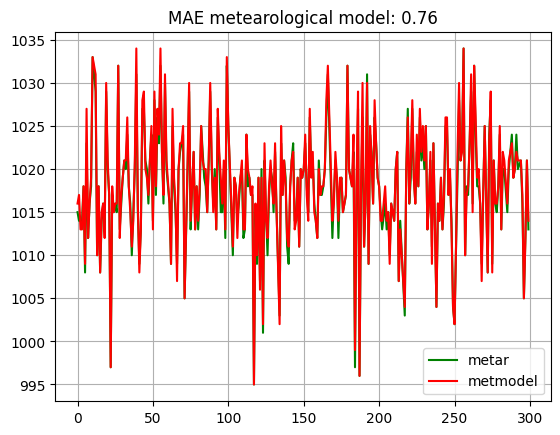

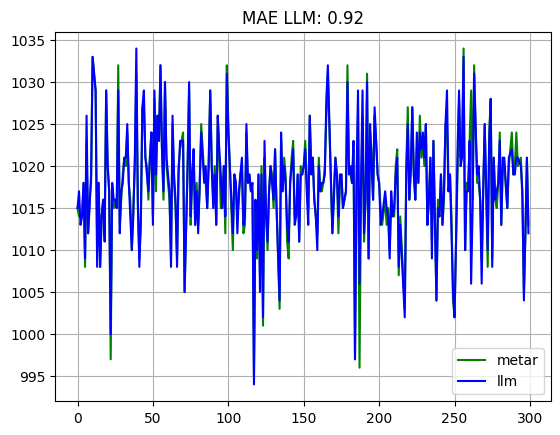

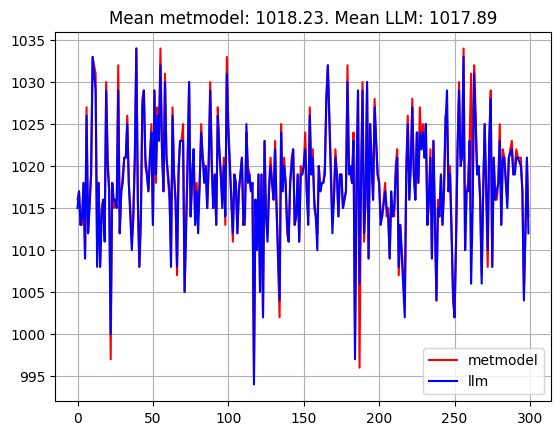

In [3]:
#@title QNH check

import pandas as pd
import numpy as np
pd.options.display.max_rows = 999

score = []

def flatten_list(list_s):
  numbers = []
  for sublist in list_s:
      for item in sublist:
          # Check if the string after 'q' is not empty
          if len(item) > 1:
              num = item[1:]
              if num.isdigit():
                  numbers.append(int(num))


  return np.array(numbers)

df = pd.read_csv(result_path)
q_ytest = []
q_ypred = []
q_metmod =[]
for i in range(0,len(df)):
  q_ytest.append([word for word in df["y_test"][i].split() if 'q' in word.lower()])
  q_ypred.append([word for word in df["y_pred"][i].split() if 'q' in word.lower()][:1])
  q_metmod.append([word for word in df["all"][i].split() if 'q' in word.lower()][:1])

q_ypred_f = []

for sublist in q_ypred:
    if not sublist:  # Check if the sublist is empty
        q_ypred_f.append(["q0000"])
    else:
        q_ypred_f.append(sublist)  # Append the single string element


q_ypred_n = flatten_list(q_ypred_f)
q_test_n = flatten_list(q_ytest)
q_metmod_n = flatten_list(q_metmod)


#Show results
df_res = pd.DataFrame({"metar":q_test_n,"metmodel":q_metmod_n,"llm":q_ypred_n})

#avoid 0
df_res = df_res[df_res.llm!=0]
mae_llm = round((df_res['metar'] - df_res['llm']).abs().mean(),2)
mae_metmod = round(np.mean(np.abs(q_metmod_n - q_test_n)),2)

score.append(mae_llm)
score.append(mae_metmod)

df_res[["metar","metmodel"]].plot(grid=True, color=['green', 'red'],title="MAE metearological model: {}".format(mae_metmod));
df_res[["metar","llm"]].plot(grid=True, color=['green', 'blue'],title="MAE LLM: {}".format(mae_llm));
df_res[["metmodel","llm"]].plot(grid=True, color=['red', 'blue'],title="Mean metmodel: {}. Mean LLM: {}".format(round(q_metmod_n.mean(),2),round(df_res.llm.mean(),2)));

In [4]:
#@title wind check

import pandas as pd
import re
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

pd.options.display.max_rows = 999

def contains_vrb(column):
    return column.str.contains('VRB', case=False, na=False)

def detect_wind_variation_test(metar):
    # Define a regex pattern for wind direction variation
    wind_variation_pattern = r'\b(\d{3})V(\d{3})\b'

    # Search for the wind direction variation in the METAR report
    match = re.search(wind_variation_pattern, metar)
    if match:
        dir1 = match.group(1)
        dir2 = match.group(2)
        return dir1,dir2
    else:
        return -1,-1

def detect_wind_variation_llm(metar):
    # Define a regex pattern for wind direction variation
    wind_variation_pattern = r'\b(\d{3})v(\d{3})\b'

    # Search for the wind direction variation in the METAR report
    match = re.search(wind_variation_pattern, metar)
    if match:
        dir1 = match.group(1)
        dir2 = match.group(2)
        return dir1,dir2
    else:
        return -1,-1


# Function to extract wind direction, speed, and gusts
def extract_wind_llm(metar):
    # Define a regex pattern for wind direction, intensity, and gusts
    # Also include a pattern for variable wind direction (VRB)
    wind_pattern = r'\b(vrb|\d{3})(\d{2})(g\d{2})?kt\b'

    # Search for the wind information in the METAR report
    match = re.search(wind_pattern, metar)
    if match:
        wind_direction = match.group(1)
        wind_speed = match.group(2)
        wind_gust = match.group(3) if match.group(3) else 0
        return wind_direction, wind_speed, wind_gust
    else:
        return "Wind information not found"


def extract_wind_test(metar):
    # Define a regex pattern for wind direction, intensity, and gusts
    # Also include a pattern for variable wind direction (VRB)
    wind_pattern = r'\b(VRB|\d{3})(\d{2})(G\d{2})?KT\b'

    # Search for the wind information in the METAR report
    match = re.search(wind_pattern, metar)
    if match:
        wind_direction = match.group(1)
        wind_speed = match.group(2)
        wind_gust = match.group(3) if match.group(3) else 0
        return wind_direction, wind_speed, wind_gust
    else:
        return "Wind information not found"

dirtest, modtest, gtest =[],[],[]
dirllm, modllm, gllm =[],[],[]

df = pd.read_csv(result_path)

for i in range(0,len(df)):
  wind_info_test = extract_wind_test(df["y_test"][i])
  wind_info_llm = extract_wind_llm(df["y_pred"][i])

  if isinstance(wind_info_test, tuple):
    dir, mod, gust = wind_info_test
    dirtest.append(dir)
    modtest.append(mod)
    gtest.append(gust)

  else:
    print(wind_info_test)
    dirtest.append(np.nan)
    modtest.append(np.nan)
    gtest.append(np.nan)

  if isinstance(wind_info_llm, tuple):
    dir, mod, gust = wind_info_llm
    dirllm.append(dir)
    modllm.append(mod)
    gllm.append(gust)

  else:
    print(wind_info_llm,i)
    dirllm.append(np.nan)
    modllm.append(np.nan)
    gllm.append(np.nan)

df["dirtest"]=dirtest
df["modtest"]=modtest
df["gtest"]=gtest

df["dirllm"]=dirllm
df["modllm"]=modllm
df["gllm"]=gllm

for i in range(0,len(df)):
  if "G" in str(df['gtest'][i]):
    df["gtest"][i]= int(df['gtest'][i][1:])

for i in range(0,len(df)):
  if "g" in str(df['gllm'][i]):
    df["gllm"][i]= int(df['gllm'][i][1:])

dirmetmod =[]
for i in range(0,len(df)):
  dirmetmod.append(int(df["all"][i].split()[0][:3]))
df["dirmetmod"] = dirmetmod

modmetmod =[]
for i in range(0,len(df)):
  modmetmod.append(int(df["all"][i].split()[0][3:5]))
df["modmetmod"] = modmetmod

dirvar = []
for i in range(0,len(df)):
  dirvar.append(detect_wind_variation_test(df["y_test"][i]))
df["dirvartest"] = dirvar

dirvar = []
for i in range(0,len(df)):
  dirvar.append(detect_wind_variation_llm(df["y_pred"][i]))
df["dirvarllm"] = dirvar
df.set_index("time")

#Analytics
mask_dirtest = contains_vrb(df['dirtest'])
mask_dirllm = contains_vrb(df['dirllm'])

# Combine the masks to filter rows
df_dir = df[~(mask_dirtest | mask_dirllm)][["dirtest","dirllm","dirmetmod"]].dropna().astype(int)

mae = int(np.mean(np.abs(df_dir['dirtest'] - df_dir['dirmetmod'])))
print(f"Mean Absolute Error (degrees) wind direction metmodel and metar: {mae}")
score.append(mae)
#MAE dir no vrb llm metar
mae = int((np.mean(np.abs(df_dir['dirtest'] - df_dir['dirllm']))))
print(f"Mean Absolute Error (degrees) wind direction llm and metar: {mae}")
score.append(mae)
df_mod= df[['modmetmod',"modtest","modllm"]].dropna().astype(int)

mae = round(np.mean(np.abs(df_mod['modtest'] - df_mod['modmetmod'])),2)
print(f"Mean Absolute Error (Kt) wind intensity metmodel and metar: {mae}")
score.append(mae)

#MAE dir no vrb llm metar
mae = round(np.mean(np.abs(df_mod['modtest'] - df_mod['modllm'])),2)
print(f"Mean Absolute Error (kt) wind intensity llm and metar: {mae}")
score.append(mae)

dirvary = sum([1 if (df["dirvarllm"][c][0]!=-1) & (df["dirvartest"][c][0]!=-1) else 0 for c in range(0,len(df))])
dirvarn = sum([1 if (df["dirvarllm"][c][0]==-1) & (df["dirvartest"][c][0]==-1) else 0 for c in range(0,len(df))])
print("Both metar and forecast direction variation:", round(dirvary/len(df),2))
print("Both metar and forecast no direction variation:",round(dirvarn/len(df),2))
print("No match between metar and forecast:", round((len(df)-dirvary-dirvarn)/len(df),2))

display(df.set_index("time")[["dirtest","dirllm","dirmetmod","dirvartest","dirvarllm", "modtest",	"modmetmod","modllm","gtest","gllm"]].head(20))

Wind information not found 134
Wind information not found 164
Mean Absolute Error (degrees) wind direction metmodel and metar: 59
Mean Absolute Error (degrees) wind direction llm and metar: 65
Mean Absolute Error (Kt) wind intensity metmodel and metar: 2.7
Mean Absolute Error (kt) wind intensity llm and metar: 2.36
Both metar and forecast direction variation: 0.38
Both metar and forecast no direction variation: 0.19
No match between metar and forecast: 0.43


,dirtest,dirllm,dirmetmod,dirvartest,dirvarllm,modtest,modmetmod,modllm,gtest,gllm
time,,,,,,,,,,
2022-03-26 06:00:00,280,230,100,"(200, 350)","(-1, -1)",03,9,06,0,0
2021-02-11 23:00:00,VRB,230,250,"(-1, -1)","(190, 260)",06,11,10,0,0
2018-09-04 23:00:00,340,vrb,20,"(310, 010)","(-1, -1)",03,1,02,0,0
2021-08-25 22:00:00,000,vrb,110,"(-1, -1)","(-1, -1)",00,3,01,0,0
2018-08-23 01:00:00,340,vrb,60,"(290, 010)","(-1, -1)",04,1,02,0,0
2021-04-28 20:00:00,020,030,10,"(350, 060)","(330, 090)",12,15,08,0,0
2019-01-10 22:00:00,270,230,120,"(240, 300)","(200, 260)",03,5,05,0,0
2022-04-26 16:00:00,200,vrb,240,"(150, 230)","(-1, -1)",11,9,08,0,0
2022-09-03 13:00:00,300,070,270,"(270, 340)","(340, 150)",09,11,05,0,0


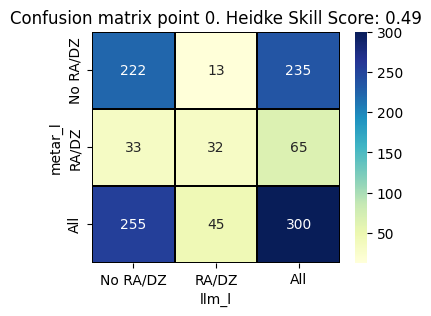

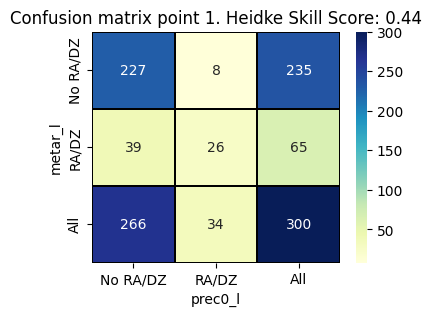

In [5]:
#@title Precipitation check

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

pd.set_option('display.max_rows', 100)
df = pd.read_csv(result_path)

df["metar_l"] = "No RA/DZ"
mask = df['y_test'].str.contains("RA")
df.loc[mask,["metar_l"]] = "RA/DZ"
mask = df['y_test'].str.contains("DZ")
df.loc[mask,["metar_l"]] = "RA/DZ"

df["llm_l"] = "No RA/DZ"
mask = df['y_pred'].str.contains("ra")
df.loc[mask,["llm_l"]] = "RA/DZ"
mask = df['y_pred'].str.contains("dz")
df.loc[mask,["llm_l"]] = "RA/DZ"

df["prec0_l"] = "No RA/DZ"
mask = df['all'].str.contains("prec0y")
df.loc[mask,["prec0_l"]] = "RA/DZ"

# Confussion matrix and Heidke skill score
cm0 = pd.crosstab(df.metar_l, df.llm_l,margins=True)
a = cm0.values[0,0]
b = cm0.values[1,0]
c = cm0.values[0,1]
d = cm0.values[1,1]
HSS0 = round(2*(a*d-b*c)/((a+c)*(c+d)+(a+b)*(b+d)),2)
score.append(HSS0)

cm1 = pd.crosstab(df.metar_l, df.prec0_l,margins=True)
a = cm1.values[0,0]
b = cm1.values[1,0]
c = cm1.values[0,1]
d = cm1.values[1,1]
HSS1 = round(2*(a*d-b*c)/((a+c)*(c+d)+(a+b)*(b+d)),2)
score.append(HSS1)

plt.figure(figsize=(4, 3))
plt.title("Confusion matrix point 0. Heidke Skill Score: {}".format(HSS0))
seab0 = sns.heatmap(cm0,annot=True,cmap="YlGnBu",fmt='.0f',linewidths=.2,linecolor='black');
plt.show()

plt.figure(figsize=(4, 3))
plt.title("Confusion matrix point 1. Heidke Skill Score: {}".format(HSS1))
seab1 = sns.heatmap(cm1,annot=True,cmap="YlGnBu",fmt='.0f',linewidths=.2,linecolor='black');
plt.show()


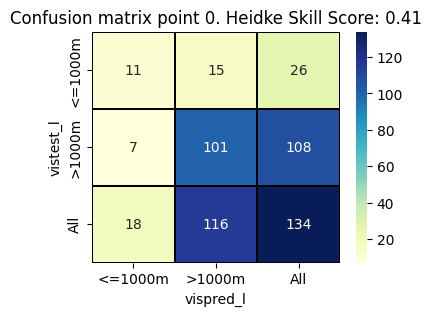

In [6]:
#@title Visibility check

import pandas as pd
import re
import matplotlib.pyplot as plt
import seaborn as sns

pd.options.display.max_rows = 999

def extract_visibility(metar):
    # Check if 'CAVOK' is in the METAR report
    if 'CAVOK' in metar:
        return '9999'
    if "cavok" in metar:
        return "9999"
    # Define a regex pattern for visibility
    visibility_pattern = r'\b(\d{4}|(\d+/\d+)?SM)\b'

    # Search for the visibility in the METAR report
    match = re.search(visibility_pattern, metar)
    if match:
        return int(match.group(0))
    else:
        return "Visibility information not found"

df = pd.read_csv(result_path)

vistest = []
vispred = []
for i in range(0,len(df)):
  vistest.append(extract_visibility(df["y_test"][i]))
  vispred.append(extract_visibility(df["y_pred"][i]))

df["vistest"]= vistest
df["vispred"]= vispred
df[['y_test', 'y_pred', 'all', 'vistest', 'vispred']]


#visibility to interval
interval = pd.IntervalIndex.from_tuples([(-0.1,1000), (1000, 40000)])
labels = ['<=1000m', '>1000m']
df["vistest_l"] = pd.cut(df["vistest"], bins=interval,retbins=False,
                        labels=labels).map({a:b for a,b in zip(interval,labels)}).astype("category")
df["vispred_l"] = pd.cut(df["vispred"], bins=interval,retbins=False,
                        labels=labels).map({a:b for a,b in zip(interval,labels)}).astype("category")

cm0 = pd.crosstab(df.vistest_l, df.vispred_l,margins=True)
a = cm0.values[0,0]
b = cm0.values[1,0]
c = cm0.values[0,1]
d = cm0.values[1,1]
HSS0 = round(2*(a*d-b*c)/((a+c)*(c+d)+(a+b)*(b+d)),2)
score.append(HSS0)

plt.figure(figsize=(4, 3))
plt.title("Confusion matrix point 0. Heidke Skill Score: {}".format(HSS0))
seab0 = sns.heatmap(cm0,annot=True,cmap="YlGnBu",fmt='.0f',linewidths=.2,linecolor='black');
plt.show()

In [7]:
#@title Temperature check

import pandas as pd
import re
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

def extract_temperature_test(metar):
    # Define a regex pattern to match the temperature (TT/DD)
    temperature_pattern = r'\b(M?\d{2})/(M?\d{2})\b'

    # Search for the temperature pattern in the METAR report
    match = re.search(temperature_pattern, metar)
    if match:
        temperature = match.group(1)
        if 'M' in temperature:
            temperature = -int(temperature.replace('M', ''))
        else:
            temperature = int(temperature)
        return temperature
    else:
        return None


def extract_temperature_llm(metar):
    # Define a regex pattern to match the temperature (TT/DD)
    temperature_pattern = r'\b(m?\d{2}) (m?\d{2})\b'

    # Search for the temperature pattern in the METAR report
    match = re.search(temperature_pattern, metar)
    if match:
        temperature = match.group(1)
        if 'm' in temperature:
            temperature = -int(temperature.replace('m', ''))
        else:
            temperature = int(temperature)
        return temperature
    else:
        return None


templlm,tempmetar,tempmetmod, tempmetmodraw =[],[],[],[]
for i in range (0,len(df)):
  tempmetar.append(extract_temperature_test(df["y_test"][i]))
  templlm.append(extract_temperature_llm(df["y_pred"][i]))
  tempmetmodraw.append(df["all"][i].split()[5])

tempmetmod = [-int(temperature.replace('M', '')) if 'M' in temperature else int(temperature) for temperature in tempmetmodraw]
df_temp=pd.DataFrame({"tempmetar":tempmetar,"templlm":templlm,"tempmetmod":tempmetmod}).dropna()


mae = round(np.mean(np.abs(df_temp['tempmetar'] - df_temp['tempmetmod'])),2)
std = round((df_temp['tempmetar'] - df_temp['tempmetmod']).std(),2)
print(f"Mean Absolute Error (degrees) temperature metmodel and metar: {mae}")
print(f"Standard desviation differences (degrees) temperature metmodel and metar: {std}")
score.append(mae)
score.append(std)

#MAE dir no vrb llm metar
mae = round(np.mean(np.abs(df_temp['tempmetar'] - df_temp['templlm'])),2)
std = round((df_temp['tempmetar'] - df_temp['templlm']).std(),2)
print(f"Mean Absolute Error temperature (degreees) llm and metar: {mae}")
print(f"Standard desviation differences (degrees) temperature LLM and metar: {std}")
score.append(mae)
score.append(std)
df_temp.head(20)

Mean Absolute Error (degrees) temperature metmodel and metar: 1.33
Standard desviation differences (degrees) temperature metmodel and metar: 1.58
Mean Absolute Error temperature (degreees) llm and metar: 1.37
Standard desviation differences (degrees) temperature LLM and metar: 1.8


,tempmetar,templlm,tempmetmod
0,15,12.0,11
1,12,13.0,12
2,17,21.0,17
3,19,21.0,18
4,17,20.0,17
5,12,9.0,10
6,6,7.0,7
7,15,13.0,17
8,21,20.0,20
9,12,11.0,10


In [8]:
#@title Save score

df_score = pd.DataFrame(score,index=["MAE_QNH_llm","MAE_QNH_metmodel","MAE_dir_metmodel",
                          "MAE_dir_llm","MAE_wind_int_metmodel","MAE_wind_int_llm",
                          "HSS_prec_llm","HSS_prec_metmodel","HHS_vis_llm","MAE_temp_metmodel","Std_temp_diff_metmodel",
                          "MAE_temp_llm","Std_temp_diff_metmodel"], columns=["Score"])
score_path = "/content/drive/MyDrive/Colab Notebooks/gpt/LEVX/LEVXscore.csv"
df_score.to_csv(score_path)

In [9]:
df_score

,Score
MAE_QNH_llm,0.92
MAE_QNH_metmodel,0.76
MAE_dir_metmodel,59.00
MAE_dir_llm,65.00
MAE_wind_int_metmodel,2.70
MAE_wind_int_llm,2.36
HSS_prec_llm,0.49
HSS_prec_metmodel,0.44
HHS_vis_llm,0.41
MAE_temp_metmodel,1.33
